In [35]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import LogLocator
from matplotlib.lines import Line2D
from copy import deepcopy
import torch 
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import os
import time
import gc
import scipy
from scipy.signal import butter, filtfilt, argrelextrema
from scipy.interpolate import interp1d
from mup import MuReadout, MuSGD, MuAdam
import mup as mup
from pathlib import Path

device = 'mps'


In [36]:
##### Smoothing features #####
def lower_envelope(x,y):
    minima_idx = argrelextrema(y, np.less, order=1)[0]
    x_sampled = x[minima_idx]
    y = y[minima_idx]
    interp = interp1d(x_sampled, y, kind='linear', fill_value='extrapolate')
    y = interp(x)
    return np.array([x, y]).transpose()

def upper_envelope(x,y):
    maxima_idx = argrelextrema(y, np.greater, order=2)[0]
    x_sampled = x[maxima_idx]
    y = y[maxima_idx]
    interp = interp1d(x_sampled, y, kind='linear', fill_value='extrapolate')
    y = interp(x)
    return np.array([x, y]).transpose()

def low_pass_filter(y, f_c, order = 5):
    b, a = butter(order, f_c, btype='low')
    return filtfilt(b,a,y)

In [37]:
##### Load a dictionnary of curves related to the training of several models and plot interesting datas about the training dynamic #####

### LOAD ###
def load_data_dictionnary(model_file_name, date):
    """ Data contains are : training_loss, validation_loss, accuracy, kappa_training_loss, kappa_validation_loss, kappa_accuracy"""
    training_loss = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_file_name + '/figures/training_loss_of_' + date + '_' + model_file_name +'.txt', delimiter=",", skiprows=1)
    validation_loss = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_file_name + '/figures/validation_loss_of_' + date + '_' + model_file_name +'.txt', delimiter=",", skiprows=1)
    accuracy = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_file_name + '/figures/accuracy_of_' + date + '_' + model_file_name +'.txt', delimiter=",", skiprows=1)
    kappa_training_loss = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_file_name + '/figures/kappa_training_loss_of_' + date + '_' + model_file_name +'.txt', delimiter=",", skiprows=1)
    kappa_validation_loss = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_file_name + '/figures/kappa_validation_loss_of_' + date + '_' + model_file_name +'.txt', delimiter=",", skiprows=1)
    kappa_accuracy = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_file_name + '/figures/kappa_accuracy_of_' + date + '_' + model_file_name +'.txt', delimiter=",", skiprows=1)
    
    model_data_dictionnary = {'training loss' : training_loss, 'validation loss' : validation_loss, 'accuracy' : accuracy, 
                        'kappa training loss' : kappa_training_loss, 'kappa validation loss' : kappa_validation_loss,
                        'kappa accuracy' : kappa_accuracy}    
    
    if os.path.exists('Classifiers/' + date + '/' + date + '_' +  model_file_name + '/' + 'fraction_minibatch' + model_file_name + '.txt') :
        fraction_minibatch = torch.load('Classifiers/' + date + '/' + date + '_' +  model_file_name + '/' + date + '_' + 'fraction_minibatch' + model_file_name + '.txt',  delimiter=",", skiprows=1)
        model_data_dictionnary['fraction minibatch'] = fraction_minibatch

    if os.path.exists('Classifiers/' + date + '/' + date + '_' +  model_file_name + '/figures/accuracy_of_' + date + '_' + model_file_name + '_last_layer_fine_tuned' +'.txt') :
        training_loss_fine_tuned = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_file_name + '/figures/training_loss_of_' + date + '_' + model_file_name + '_last_layer_fine_tuned' + '.txt', delimiter=",", skiprows=1)
        validation_loss_fine_tuned = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_file_name + '/figures/validation_loss_of_' + date + '_' + model_file_name + '_last_layer_fine_tuned' + '.txt', delimiter=",", skiprows=1)
        accuracy_fine_tuned = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_file_name + '/figures/accuracy_of_' + date + '_' + model_file_name + '_last_layer_fine_tuned' + '.txt', delimiter=",", skiprows=1)
        model_data_dictionnary = model_data_dictionnary | {'fine tuned training loss' : training_loss_fine_tuned, 'fine tuned validation loss' : validation_loss_fine_tuned, 'fine tuned accuracy' : accuracy_fine_tuned}
    
    if os.path.exists('Classifiers/' + date + '/' + date + '_' +  model_file_name + '/' + date + '_' +  model_file_name + '_first_layer_weight_bias.pt') :
        weight_bias = torch.load('Classifiers/' + date + '/' + date + '_' +  model_file_name + '/' + date + '_' +  model_file_name + '_first_layer_weight_bias.pt')
        model_data_dictionnary = model_data_dictionnary | weight_bias
    
    if os.path.exists('Classifiers/' + date + '/' + date + '_' +  model_file_name + '/' + date + '_' +  model_file_name + '_first_layer_weight_bias_trajectory.pt') :
        weight_bias = torch.load('Classifiers/' + date + '/' + date + '_' +  model_file_name + '/' + date + '_' +  model_file_name + '_first_layer_weight_bias_trajectory.pt')
        model_data_dictionnary = model_data_dictionnary | {'layers trajectories' : {1 : weight_bias}}
    
    if os.path.exists('Classifiers/' + date + '/' + date + '_' +  model_file_name + '/' + date + '_' +  model_file_name + '_second_layer_weight_bias_trajectory.pt') :
        weight_bias = torch.load('Classifiers/' + date + '/' + date + '_' +  model_file_name + '/' + date + '_' +  model_file_name + '_second_layer_weight_bias_trajectory.pt')
        model_data_dictionnary['layers trajectories'] = model_data_dictionnary['layers trajectories'] | {2 : weight_bias}
        
    return model_data_dictionnary

def load_data_dictionnary_pre_29_05(model_file_name, date):
    """ Data contains are : training_loss, validation_loss, accuracy, kappa_training_loss, kappa_validation_loss, kappa_accuracy"""
    training_loss = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_file_name + '/figures/loss_training_of_' + date + '_' + model_file_name +'.txt', delimiter=",", skiprows=1)
    validation_loss = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_file_name + '/figures/validation_loss_of_' + date + '_' + model_file_name +'.txt', delimiter=",", skiprows=1)
    accuracy = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_file_name + '/figures/accuracy_of_' + date + '_' + model_file_name +'.txt', delimiter=",", skiprows=1)
    kappa_training_loss = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_file_name + '/figures/kappa_loss_training_' + date + '_' + model_file_name +'.txt', delimiter=",", skiprows=1)
    kappa_validation_loss = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_file_name + '/figures/kappa_loss_validation_' + date + '_' + model_file_name +'.txt', delimiter=",", skiprows=1)
    kappa_accuracy = np.loadtxt('Classifiers/' + date + '/' + date + '_' +  model_file_name + '/figures/kappa_accuracy_' + date + '_' + model_file_name +'.txt', delimiter=",", skiprows=1)
    
    model_data_dictionnary = {'training loss' : training_loss, 'validation loss' : validation_loss, 'accuracy' : accuracy, 
                        'kappa training loss' : kappa_training_loss, 'kappa validation loss' : kappa_validation_loss,
                        'kappa accuracy' : kappa_accuracy}
    return model_data_dictionnary

### CONVERGENCE SPEED ###

def convergence_speed(curve, ref_curve, delta = 1e-3,observation_rate=10):
    if np.size(np.where((curve - (np.max(ref_curve)-delta) > 0))[0]) > 0 :
        return np.where((curve - (np.max(ref_curve)-delta) > 0))[0][0]*observation_rate
    else : 
        return -1e8

def convergence_speed_plot(curve_dictionnary, color_list, marker_list, x_list, delta=1e-3, save=True, save_path = '', save_name_peculiarity=''):
    convergence_speed_dictionnary = deepcopy(curve_dictionnary)
    for n_hidden_units in curve_dictionnary:
        for type_of_training in curve_dictionnary[n_hidden_units] :
            for architecture in curve_dictionnary[n_hidden_units][type_of_training]:
                if type_of_training != 'First trained + Last fine tuned' :
                    convergence_speed_dictionnary[n_hidden_units][type_of_training][architecture] = convergence_speed(curve_dictionnary[n_hidden_units][type_of_training][architecture]['accuracy'][:,1], curve_dictionnary[n_hidden_units]['Reference']['2 layers']['accuracy'][:,1], delta)
                    plt.plot(x_list[architecture], convergence_speed_dictionnary[n_hidden_units][type_of_training][architecture], marker = marker_list[type_of_training], markersize = '13', markeredgecolor = color_list[n_hidden_units], markerfacecolor = 'None')       
                else : 
                    convergence_speed_dictionnary[n_hidden_units][type_of_training][architecture] = convergence_speed(curve_dictionnary[n_hidden_units][type_of_training][architecture]['fine tuned accuracy'][:,1], curve_dictionnary[n_hidden_units]['Reference']['2 layers']['accuracy'][:,1], delta)
                    plt.plot(x_list[architecture], convergence_speed_dictionnary[n_hidden_units][type_of_training][architecture], marker = marker_list[type_of_training], markersize = '13', color = color_list[n_hidden_units])       
                 
    legend_hu = []
    legend_training_type = []
    for i, n_hidden_units in enumerate(convergence_speed_dictionnary):
        legend_hu += [Line2D([0], [0], color = color_list[n_hidden_units], marker='.', linestyle='None', label = n_hidden_units)]
        if i == 0:
            for type_of_training in convergence_speed_dictionnary[n_hidden_units]:
                if type_of_training != 'First trained + Last fine tuned' :
                    legend_training_type += [Line2D([0], [0], markeredgecolor= 'black', markerfacecolor='None', marker = marker_list[type_of_training], linestyle = 'None', label = type_of_training)]
                else : 
                    legend_training_type += [Line2D([0], [0], color= 'black', marker = marker_list[type_of_training], linestyle = 'None', label = type_of_training)]
    legend_elements = legend_hu + legend_training_type
    legend = plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
    for handle in legend.legend_handles:
        handle.set_markersize(15)
    plt.xlabel('Number of layers')
    plt.ylabel('Number of iterations')
    plt.title('Convergence speed of training \nfor the different architectures and types of training', pad = 20)
    y_max = np.max([convergence_speed_dictionnary[n_hidden_units][type_of_training][architecture] 
                for n_hidden_units in convergence_speed_dictionnary
                for type_of_training in convergence_speed_dictionnary[n_hidden_units]
                for architecture in convergence_speed_dictionnary[n_hidden_units][type_of_training]])
    plt.ylim(-0.05*y_max, 1.05*y_max)
    plt.xticks([x for key, x in x_list.items()])
    plt.grid()
    if save :
        plt.savefig(save_path + 'convergence_speed_' + save_name_peculiarity + '.png', bbox_inches='tight')
        plt.savefig(save_path + 'convergence_speed_' + save_name_peculiarity + '.svg', bbox_inches='tight')
    plt.show()  
    return

def normalized_convergence_speed_plot(curve_dictionnary, color_list, marker_list, x_list, delta=1e-3, save=True, save_path = '', save_name_peculiarity=''):
    convergence_speed_dictionnary = deepcopy(curve_dictionnary)
    for n_hidden_units in curve_dictionnary:
        for type_of_training in curve_dictionnary[n_hidden_units] :
            for architecture in curve_dictionnary[n_hidden_units][type_of_training]:
                if type_of_training != 'First trained + Last fine tuned' :
                    convergence_speed_dictionnary[n_hidden_units][type_of_training][architecture] = convergence_speed(curve_dictionnary[n_hidden_units][type_of_training][architecture]['accuracy'][:,1], curve_dictionnary[n_hidden_units]['Reference']['2 layers']['accuracy'][:,1], delta)/convergence_speed(curve_dictionnary[n_hidden_units]['Reference']['2 layers']['accuracy'][:,1], curve_dictionnary[n_hidden_units]['Reference']['2 layers']['accuracy'][:,1], delta)
                    if type_of_training == 'Reference':
                        plt.plot(x_list[architecture], convergence_speed_dictionnary[n_hidden_units][type_of_training][architecture], marker = marker_list[type_of_training], markersize = '12', color = 'black')
                    else :
                        plt.plot(x_list[architecture], convergence_speed_dictionnary[n_hidden_units][type_of_training][architecture], marker = marker_list[type_of_training], markersize = '12', markerfacecolor = 'none', markeredgecolor = color_list[n_hidden_units])
                else :
                    convergence_speed_dictionnary[n_hidden_units][type_of_training][architecture] = convergence_speed(curve_dictionnary[n_hidden_units][type_of_training][architecture]['fine tuned accuracy'][:,1], curve_dictionnary[n_hidden_units]['Reference']['2 layers']['accuracy'][:,1], delta)/convergence_speed(curve_dictionnary[n_hidden_units]['Reference']['2 layers']['accuracy'][:,1], curve_dictionnary[n_hidden_units]['Reference']['2 layers']['accuracy'][:,1], delta)
                    plt.plot(x_list[architecture], convergence_speed_dictionnary[n_hidden_units][type_of_training][architecture], marker = marker_list[type_of_training], markersize = '12', markerfacecolor = color_list[n_hidden_units], markeredgecolor = color_list[n_hidden_units])

    legend_hu = []
    legend_training_type = []
    for i, n_hidden_units in enumerate(convergence_speed_dictionnary):
        legend_hu += [Line2D([0], [0], color = color_list[n_hidden_units], marker='.', linestyle='None', label = n_hidden_units)]
        if i == 0:
            for type_of_training in convergence_speed_dictionnary[n_hidden_units]:
                if type_of_training != 'First trained + Last fine tuned' :
                    legend_training_type += [Line2D([0], [0], marker = marker_list[type_of_training], linestyle='None', markeredgecolor='black', markerfacecolor='None', label = type_of_training)]
                else : 
                    legend_training_type += [Line2D([0], [0], marker = marker_list[type_of_training], linestyle='None', markeredgecolor='black', markerfacecolor='black', label = type_of_training)]
    legend_elements = legend_hu + legend_training_type
    legend = plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
    for handle in legend.legend_handles:
        handle.set_markersize(15)
    plt.xlabel('Number of layers')
    plt.ylabel('Number of iterations')
    plt.title('Normalized convergence speed of training \nfor different architectures and types of training', pad = 20)
    y_max = np.max([convergence_speed_dictionnary[n_hidden_units][type_of_training][architecture] 
                for n_hidden_units in convergence_speed_dictionnary
                for type_of_training in convergence_speed_dictionnary[n_hidden_units]
                for architecture in convergence_speed_dictionnary[n_hidden_units][type_of_training]])
    plt.ylim(-0.1, y_max + 0.1)
    plt.xticks([x for key, x in x_list.items()])
    plt.grid()
    if save :
        plt.savefig(save_path + 'normalized_convergence_speed_' + save_name_peculiarity + '.png', bbox_inches='tight')
        plt.savefig(save_path + 'normalized_convergence_speed_' + save_name_peculiarity + '.svg', bbox_inches='tight')
    plt.show()  
    return

### MAXIMUM ACCURACY ###

def max_accuracy_plot(curve_dictionnary, color_list, marker_list, x_list, save=True, save_path = '', save_name_peculiarity='') :
    max_accuracy_dictionnary = deepcopy(curve_dictionnary)
    for n_hidden_units in curve_dictionnary:
        for type_of_training in curve_dictionnary[n_hidden_units] :
            for architecture in curve_dictionnary[n_hidden_units][type_of_training]:
                if type_of_training != 'First trained + Last fine tuned' :
                    max_accuracy_dictionnary[n_hidden_units][type_of_training][architecture] = np.max(curve_dictionnary[n_hidden_units][type_of_training][architecture]['accuracy'][:,1])
                    plt.plot(x_list[architecture], max_accuracy_dictionnary[n_hidden_units][type_of_training][architecture], marker = marker_list[type_of_training], markersize = '12', markerfacecolor = 'None', markeredgecolor = color_list[n_hidden_units])
                else : 
                    max_accuracy_dictionnary[n_hidden_units][type_of_training][architecture] = np.max(curve_dictionnary[n_hidden_units][type_of_training][architecture]['fine tuned accuracy'][:,1])
                    plt.plot(x_list[architecture], max_accuracy_dictionnary[n_hidden_units][type_of_training][architecture], marker = marker_list[type_of_training], markersize = '12', markerfacecolor = color_list[n_hidden_units], markeredgecolor = color_list[n_hidden_units])

    legend_hu = []
    legend_training_type = []
    for i, n_hidden_units in enumerate(max_accuracy_dictionnary):
        legend_hu += [Line2D([0], [0], color = color_list[n_hidden_units], marker = '.', linestyle='None', label = n_hidden_units)]
        if i == 0:
            for type_of_training in max_accuracy_dictionnary[n_hidden_units]:
                if type_of_training != 'First trained + Last fine tuned' :
                    legend_training_type += [Line2D([0], [0], markeredgecolor = 'black', markerfacecolor = 'None', marker = marker_list[type_of_training], linestyle='None', label = type_of_training)]
                else : 
                    legend_training_type += [Line2D([0], [0], markeredgecolor = 'black', markerfacecolor = 'black', marker = marker_list[type_of_training], linestyle='None', label = type_of_training)]
    legend_elements = legend_hu + legend_training_type
    legend = plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
    for handle in legend.legend_handles:
        handle.set_markersize(15)
    plt.xlabel('Number of layers')
    plt.ylabel('Accuracy')
    plt.title('Maximum accuracy for\n the different architectures and types of training', pad = 20)
    y_max = np.max([max_accuracy_dictionnary[n_hidden_units][type_of_training][architecture] 
                for n_hidden_units in max_accuracy_dictionnary
                for type_of_training in max_accuracy_dictionnary[n_hidden_units]
                for architecture in max_accuracy_dictionnary[n_hidden_units][type_of_training]])
    y_min = np.min([max_accuracy_dictionnary[n_hidden_units][type_of_training][architecture] 
                for n_hidden_units in max_accuracy_dictionnary
                for type_of_training in max_accuracy_dictionnary[n_hidden_units]
                for architecture in max_accuracy_dictionnary[n_hidden_units][type_of_training]])
    plt.ylim(y_min - 0.01, y_max + 0.01)
    plt.xticks([x for key, x in x_list.items()])
    plt.grid()
    if save :
        plt.savefig(save_path + 'max_accuracy_' + save_name_peculiarity + '.png', bbox_inches='tight')
        plt.savefig(save_path + 'max_accuracy_' + save_name_peculiarity + '.svg', bbox_inches='tight')
    plt.show()  
    return

### ACCURACY TRAJECTORY ###

def accuracy_trajectory_plot(curve_dictionnary, color_list, marker_list, x_lim = None, y_lim = None, save=True, save_path = '', save_name_peculiarity='', observation_rate = 10) :
    for n_hidden_units in curve_dictionnary:
        for type_of_training in curve_dictionnary[n_hidden_units] :
            for architecture in curve_dictionnary[n_hidden_units][type_of_training]:
                if type_of_training != 'First trained + Last fine tuned' :
                    accuracy = curve_dictionnary[n_hidden_units][type_of_training][architecture]['accuracy']
                    x_max = x_lim[1] if x_lim is not None else curve_dictionnary[n_hidden_units][type_of_training][architecture]['accuracy'][:,0][-1]*observation_rate
                    accuracy[:,1] = low_pass_filter(accuracy[:,1], 0.10)
                    len_accuracy = len(accuracy[accuracy[:,0] < x_max])
                    plt.plot(accuracy[:,0], accuracy[:,1], marker = marker_list[type_of_training], markersize = '11', markerfacecolor = 'None', markeredgecolor = color_list[n_hidden_units][architecture], markevery = int(len_accuracy/10), color = color_list[n_hidden_units][architecture])
                            
                else :
                    accuracy = curve_dictionnary[n_hidden_units][type_of_training][architecture]['fine tuned accuracy']
                    plt.plot(accuracy[:,0], accuracy[:,1], marker = marker_list[type_of_training], markersize = '11', markerfacecolor = color_list[n_hidden_units][architecture], markeredgecolor = color_list[n_hidden_units][architecture], color = color_list[n_hidden_units][architecture])
    labels=[]
    legend_hu = []
    legend_training_type = []
    for i, n_hidden_units in enumerate(curve_dictionnary):
        for j, type_of_training in enumerate(curve_dictionnary[n_hidden_units]):
            for k, architecture in enumerate(curve_dictionnary[n_hidden_units][type_of_training]):
                if i == 0 and k == 0:
                    if type_of_training != 'First trained + Last fine tuned' :
                        legend_training_type += [Line2D([0], [0], markeredgecolor = 'black', markerfacecolor = 'None', marker = marker_list[type_of_training], linestyle='None', label = type_of_training)]
                    else : 
                        legend_training_type += [Line2D([0], [0], markeredgecolor = 'black', markerfacecolor = 'black', marker = marker_list[type_of_training], linestyle='None', label = type_of_training)]
                if np.sum([n_hidden_units + ' - ' + architecture==label for label in labels])==0:    
                    legend_hu += [Line2D([0], [0], color = color_list[n_hidden_units][architecture], linewidth=5, label = n_hidden_units + ' - ' + architecture)]
                    labels += [n_hidden_units + ' - ' + architecture]
    legend_elements = legend_hu + legend_training_type
    legend = plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
    for handle in legend.legend_handles:
        handle.set_markersize(15)
    plt.xlabel('Number of iterations')
    plt.ylabel('Accuracy')
    plt.title('Accuracy during training for\n the different architectures and types of training', pad = 20)
    x_max = np.max([np.max(curve_dictionnary[n_hidden_units][type_of_training][architecture]['accuracy'][:,0])
                    for n_hidden_units in curve_dictionnary
                    for type_of_training in curve_dictionnary[n_hidden_units]
                    for architecture in curve_dictionnary[n_hidden_units][type_of_training]]) if x_lim == None else x_lim[1]
    plt.xlim(-100, x_max)
    y_max = np.max([np.max(curve_dictionnary[n_hidden_units][type_of_training][architecture]['accuracy'][:,1])
                for n_hidden_units in curve_dictionnary
                for type_of_training in curve_dictionnary[n_hidden_units]
                for architecture in curve_dictionnary[n_hidden_units][type_of_training]]) if y_lim == None else y_lim[1] 
    y_min = np.min([np.min(curve_dictionnary[n_hidden_units][type_of_training][architecture]['accuracy'][:,1])
                for n_hidden_units in curve_dictionnary
                for type_of_training in curve_dictionnary[n_hidden_units]
                for architecture in curve_dictionnary[n_hidden_units][type_of_training]]) if y_lim == None else y_lim[0] 
    
    plt.ylim(y_min - 0.01, y_max + 0.01)
    plt.grid()
    if save :
        plt.savefig(save_path + 'accuracy_trajectories' + save_name_peculiarity + '.png', bbox_inches='tight')
        plt.savefig(save_path + 'accuracy_trajectories' + save_name_peculiarity + '.svg', bbox_inches='tight')
    plt.show()  
    return

### LOSS TRAJECTORY ###

def loss_trajectory_plot(curve_dictionnary, color_list, marker_list, x_lim = None, y_lim = None, save=True, save_path = '', save_name_peculiarity='', observation_rate = 10) :
    for n_hidden_units in curve_dictionnary:
        for type_of_training in curve_dictionnary[n_hidden_units] :
            for architecture in curve_dictionnary[n_hidden_units][type_of_training]:
                if type_of_training != 'First trained + Last fine tuned':
                    training_loss = curve_dictionnary[n_hidden_units][type_of_training][architecture]['training loss']
                    validation_loss = curve_dictionnary[n_hidden_units][type_of_training][architecture]['validation loss']
                    training_loss[:,1] = low_pass_filter(training_loss[:,1], 0.30)
                    validation_loss[:,1] = low_pass_filter(validation_loss[:,1], 0.30)
                    x_max = x_lim[1] if x_lim is not None else training_loss[:,0][-1]*observation_rate
                    len_training_loss = len(training_loss[training_loss[:,0] < x_max])
                    plt.plot(training_loss[:,0], training_loss[:,1], marker = marker_list[type_of_training], markersize = '11', markerfacecolor = 'None', markeredgecolor = color_list[n_hidden_units][architecture], markevery = int(len_training_loss/10), color = color_list[n_hidden_units][architecture])
                    x_max = x_lim[1] if x_lim is not None else validation_loss[:,0][-1]*observation_rate
                    len_validation_loss = len(validation_loss[validation_loss[:,0] < x_max])
                    plt.plot(validation_loss[:,0], validation_loss[:,1], marker = marker_list[type_of_training], markersize = '11', markerfacecolor = 'None', markeredgecolor = color_list[n_hidden_units][architecture], markevery = int(len_validation_loss/10), linestyle = ':', color = color_list[n_hidden_units][architecture])
        
                else : 
                    training_loss = curve_dictionnary[n_hidden_units][type_of_training][architecture]['fine tuned training loss']
                    plt.plot(training_loss[:,0], training_loss[:,1], marker = marker_list[type_of_training], markersize = '11', markerfacecolor = color_list[n_hidden_units][architecture], markeredgecolor = color_list[n_hidden_units][architecture], color = color_list[n_hidden_units][architecture])
                    validation_loss = curve_dictionnary[n_hidden_units][type_of_training][architecture]['fine tuned validation loss']
                    plt.plot(validation_loss[:,0], validation_loss[:,1], marker = marker_list[type_of_training], markersize = '11', markerfacecolor = color_list[n_hidden_units][architecture], markeredgecolor = color_list[n_hidden_units][architecture], linestyle = ':', color = color_list[n_hidden_units][architecture])
    labels=[]
    legend_hu = []
    legend_training_type = []
    legend_loss_type = [Line2D([0], [0], color = 'black', label = 'Training loss'), 
                        Line2D([0], [0], color = 'black', linestyle = ':', label = 'Validation_loss')]
    for i, n_hidden_units in enumerate(curve_dictionnary):
        for j, type_of_training in enumerate(curve_dictionnary[n_hidden_units]): 
            for k, architecture in enumerate(curve_dictionnary[n_hidden_units][type_of_training]):
                if i == 0 and k == 0:
                    if type_of_training != 'First trained + Last fine tuned' :
                        legend_training_type += [Line2D([0], [0], markeredgecolor = 'black', markerfacecolor = 'None', marker = marker_list[type_of_training], linestyle='None', label = type_of_training)]
                    else : 
                        legend_training_type += [Line2D([0], [0], markeredgecolor = 'black', markerfacecolor = 'black', marker = marker_list[type_of_training], linestyle='None', label = type_of_training)]
                if np.sum([n_hidden_units + ' - ' + architecture==label for label in labels])==0:    
                    legend_hu += [Line2D([0], [0], color = color_list[n_hidden_units][architecture], linewidth=5, label = n_hidden_units + ' - ' + architecture)]
                    labels += [n_hidden_units + ' - ' + architecture]
    legend_elements = legend_loss_type + legend_hu + legend_training_type
    legend = plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
    for handle in legend.legend_handles:
        handle.set_markersize(15)
    plt.xlabel('Number of iterations')
    plt.ylabel('Loss')
    plt.title('Loss during training for \nthe different architectures and types of training', pad = 20)
    x_max = np.max([np.max(curve_dictionnary[n_hidden_units][type_of_training][architecture]['training loss'][:,0])
                    for n_hidden_units in curve_dictionnary
                    for type_of_training in curve_dictionnary[n_hidden_units]
                    for architecture in curve_dictionnary[n_hidden_units][type_of_training]]) if x_lim == None else x_lim[1]
    plt.xlim(0, x_max)
    y_max = np.max([np.max(curve_dictionnary[n_hidden_units][type_of_training][architecture]['training loss'][:,1]) 
                for n_hidden_units in curve_dictionnary
                for type_of_training in curve_dictionnary[n_hidden_units]
                for architecture in curve_dictionnary[n_hidden_units][type_of_training]]
                + [np.max(curve_dictionnary[n_hidden_units][type_of_training][architecture]['validation loss'][:,1])
                for n_hidden_units in curve_dictionnary
                for type_of_training in curve_dictionnary[n_hidden_units]
                for architecture in curve_dictionnary[n_hidden_units][type_of_training]]) if y_lim == None else y_lim[1]    
    plt.ylim(-0.01, y_max + 0.01)
    plt.grid()
    if save :
        plt.savefig(save_path + 'loss_trajectories' + save_name_peculiarity + '.png', bbox_inches='tight')
        plt.savefig(save_path + 'loss_trajectories' + save_name_peculiarity + '.svg', bbox_inches='tight')
    plt.show()  
    return





In [92]:
##### STATISTICS - Load a dictionnary of curves related to the training of several samples of several models and plot interesting datas about the training dynamic #####


### LOAD ###

def load_multi_saves_data_dictionnary(model_file_name, date):
    """
    Charge les résultats moyens (loss, accuracy, etc.)
    """
    model_path = Path('Classifiers') / date / f"{date}_{model_file_name}"
    model_data_dictionnary = {}
    save_index = 1

    if not model_path.exists():
        print(f"[WARNING] Dossier inexistant : {model_path}")
        return model_data_dictionnary

    for save in model_path.iterdir():
        if not save.is_dir():
            continue

        save_data = {}
        figures_path = save / 'figures'

        # Essayer de charger les fichiers principaux (avec test)
        for metric in ['training_loss', 'validation_loss', 'accuracy',
                       'kappa_training_loss', 'kappa_validation_loss', 'kappa_accuracy']:
            file_path = figures_path / f"{metric}_of_{date}_{model_file_name}.txt"
            if file_path.exists():
                save_data[metric.replace('_', ' ')] = np.loadtxt(file_path, delimiter=",", skiprows=1)

        # Essayer de charger les fichiers "last_layer_fine_tuned"
        for metric in ['training_loss', 'validation_loss', 'accuracy']:
            file_path = figures_path / f"{metric}_of_{date}_{model_file_name}_last_layer_fine_tuned.txt"
            if file_path.exists():
                save_data[f"fine tuned {metric.replace('_', ' ')}"] = np.loadtxt(file_path, delimiter=",", skiprows=1)

        # Essayer de charger les poids/biais
        first_layer_path = save / f"{date}_{model_file_name}_first_layer_weight_bias.pt"
        if first_layer_path.exists():
            try:
                weight_bias = torch.load(first_layer_path)
                save_data = save_data | weight_bias
            except Exception as e:
                print(f"[ERROR] Impossible de charger {first_layer_path} : {e}")

        # Essayer de charger les trajectoires
        layers_trajectories = {}

        first_traj_path = save / f"{date}_{model_file_name}_first_layer_weight_bias_trajectory.pt"
        if first_traj_path.exists():
            try:
                layers_trajectories[1] = torch.load(first_traj_path)
            except Exception as e:
                print(f"[ERROR] Impossible de charger {first_traj_path} : {e}")

        second_traj_path = save / f"{date}_{model_file_name}_second_layer_weight_bias_trajectory.pt"
        if second_traj_path.exists():
            try:
                layers_trajectories[2] = torch.load(second_traj_path)
            except Exception as e:
                print(f"[ERROR] Impossible de charger {second_traj_path} : {e}")

        if layers_trajectories:
            save_data['layers trajectories'] = layers_trajectories

        # Stocker dans le dictionnaire final si on a trouvé des données
        if save_data:
            model_data_dictionnary[f'save {save_index}'] = save_data
            save_index += 1

    return model_data_dictionnary


### CONVERT SEVERAL SAMPLES into ONE MEAN CURVE (+ ERROR) ###

def convert_to_statistical_data_dictionnary(model_data_dictionnary, outlier_filter=True):
    """
    model_data_dictionnary structure :
        { 'save 1': { 'metric_name': array, ... }, ... }
    Returns :
        { 'mean': {metric_name: array}, 'error': {metric_name: array} }
    """
    # Initialiser dictionnaires résultat
    statistical_curve = {'mean': {}, 'error': {}}

    # Pour chaque metric, construire la pile de toutes les saves alignées
    metrics = list(next(iter(model_data_dictionnary.values())).keys())
    n_saves = len(model_data_dictionnary)

    for metric in metrics:
            # Trouver la longueur minimale sur toutes les saves et metrics
        min_length = np.min([
            model_data_dictionnary[save][metric].shape[0]
            for save in model_data_dictionnary
        ])
        # Stack des valeurs coupées à min_length
        values_list = []
        for save in model_data_dictionnary:
            values = model_data_dictionnary[save][metric][:min_length, 1]
            values_list.append(values)
        
        # Transformer en array (n_saves x min_length)
        values_array = np.vstack(values_list)

        # Moyenne et erreur-type absolue
        mean_values = np.mean(values_array, axis=0)
        error_values = np.std(values_array, axis=0) / np.sqrt(n_saves)  # erreur-type (SEM)

        # On suppose que l'axe X est le même (prend celui du premier save)
        x_axis = model_data_dictionnary[next(iter(model_data_dictionnary))][metric][:min_length, 0]

        # Stocker résultat
        statistical_curve['mean'][metric] = np.column_stack((x_axis, mean_values))
        statistical_curve['error'][metric] = error_values/2

        if outlier_filter:
            outliers_indices = np.where(statistical_curve['error'][metric] > 0.03)
            for outlier_index in outliers_indices :
                statistical_curve['error'][metric][outlier_index] = 0
    return statistical_curve


### STATISTICAL ACCURACY ###

# The statistical curves are gathered in a statistical curves dictionnary

def statistical_accuracy_trajectory_plot(statistical_curve_dictionnary, n_saves, color_list, marker_list, x_lim = None, y_lim = None, save=True, save_path = '', save_name_peculiarity='', observation_rate = 10) :
    for n_hidden_units in statistical_curve_dictionnary:
        for type_of_training in statistical_curve_dictionnary[n_hidden_units] :
            for architecture in statistical_curve_dictionnary[n_hidden_units][type_of_training]:
                if type_of_training != 'First trained + Last fine tuned' :
                    accuracy = statistical_curve_dictionnary[n_hidden_units][type_of_training][architecture]['mean']['accuracy']
                    accuracy_error = statistical_curve_dictionnary[n_hidden_units][type_of_training][architecture]['error']['accuracy']
                    x_max = x_lim[1] if x_lim is not None else accuracy[:,0][-1]*observation_rate
                    accuracy[:,1] = low_pass_filter(accuracy[:,1], 0.10)
                    len_accuracy = len(accuracy[accuracy[:,0] < x_max])
                    # plt.errorbar(accuracy[:,0], accuracy[:,1], yerr=accuracy_error, fmt='o', capsize=2, marker = marker_list[type_of_training], markersize = '4', markerfacecolor = 'None', markeredgecolor = color_list[n_hidden_units][architecture], markevery = int(len_accuracy/10), color = color_list[n_hidden_units][architecture])
                    plt.errorbar(accuracy[:,0], accuracy[:,1], capsize=2, marker = marker_list[type_of_training], markersize = '11', markerfacecolor = 'None', markeredgecolor = color_list[n_hidden_units][architecture], markevery = int(len_accuracy/10), color = color_list[n_hidden_units][architecture])
                else :
                    accuracy = statistical_curve_dictionnary[n_hidden_units][type_of_training][architecture]['mean']['fine tuned accuracy']
                    accuracy_error = statistical_curve_dictionnary[n_hidden_units][type_of_training][architecture]['error']['fine tuned accuracy']
                    x_max = x_lim[1] if x_lim is not None else statistical_curve_dictionnary[n_hidden_units][type_of_training][architecture]['mean']['fine tuned accuracy'][:,0][-1]
                    len_accuracy = len(accuracy[accuracy[:,0] < x_max])
                    # plt.errorbar(accuracy[:,0], accuracy[:,1], yerr=accuracy_error, fmt='o', marker = marker_list[type_of_training], markersize = '4', markerfacecolor = color_list[n_hidden_units][architecture], markeredgecolor = color_list[n_hidden_units][architecture], color = color_list[n_hidden_units][architecture])
                    plt.errorbar(accuracy[:,0], accuracy[:,1], marker = marker_list[type_of_training], markersize = '11', markerfacecolor = color_list[n_hidden_units][architecture], markevery = int(len_accuracy/10), markeredgecolor = color_list[n_hidden_units][architecture], color = color_list[n_hidden_units][architecture])
    
    labels=[]
    legend_hu = []
    legend_training_type = []
    for i, n_hidden_units in enumerate(statistical_curve_dictionnary):
        for j, type_of_training in enumerate(statistical_curve_dictionnary[n_hidden_units]):
            for k, architecture in enumerate(statistical_curve_dictionnary[n_hidden_units][type_of_training]):
                if i == 0 and k == 0:
                    if type_of_training != 'First trained + Last fine tuned' :
                        legend_training_type += [Line2D([0], [0], markeredgecolor = 'black', markerfacecolor = 'None', marker = marker_list[type_of_training], linestyle='None', label = type_of_training)]
                    else : 
                        legend_training_type += [Line2D([0], [0], markeredgecolor = 'black', markerfacecolor = 'black', marker = marker_list[type_of_training], linestyle='None', label = type_of_training)]
                if np.sum([n_hidden_units + ' - ' + architecture==label for label in labels])==0:    
                    legend_hu += [Line2D([0], [0], color = color_list[n_hidden_units][architecture], linewidth=5, label = n_hidden_units + ' - ' + architecture)]
                    labels += [n_hidden_units + ' - ' + architecture]
    legend_elements = legend_hu + legend_training_type
    legend = plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
    for handle in legend.legend_handles:
        handle.set_markersize(15)
    plt.xlabel('Number of iterations')
    plt.ylabel('Accuracy')
    plt.title(f'Mean accuracy during training for\n the different architectures and types of training\non N = {n_saves} samples', pad = 20)
    x_max = np.max([np.max(statistical_curve_dictionnary[n_hidden_units][type_of_training][architecture]['mean']['accuracy'][:,0])
                    for n_hidden_units in statistical_curve_dictionnary
                    for type_of_training in statistical_curve_dictionnary[n_hidden_units]
                    for architecture in statistical_curve_dictionnary[n_hidden_units][type_of_training]]) if x_lim == None else x_lim[1]
    plt.xlim(-100, x_max)
    y_max = np.max([np.max(statistical_curve_dictionnary[n_hidden_units][type_of_training][architecture]['mean']['accuracy'][:,1])
                for n_hidden_units in statistical_curve_dictionnary
                for type_of_training in statistical_curve_dictionnary[n_hidden_units]
                for architecture in statistical_curve_dictionnary[n_hidden_units][type_of_training]]) if y_lim == None else y_lim[1] 
    y_min = np.min([np.min(statistical_curve_dictionnary[n_hidden_units][type_of_training][architecture]['mean']['accuracy'][:,1])
                for n_hidden_units in statistical_curve_dictionnary
                for type_of_training in statistical_curve_dictionnary[n_hidden_units]
                for architecture in statistical_curve_dictionnary[n_hidden_units][type_of_training]]) if y_lim == None else y_lim[0] 
    
    plt.ylim(y_min - 0.01, y_max + 0.01)
    plt.grid()
    if save :
        plt.savefig(save_path + 'accuracy_trajectories_' + save_name_peculiarity + '.png', bbox_inches='tight')
        plt.savefig(save_path + 'accuracy_trajectories_' + save_name_peculiarity + '.svg', bbox_inches='tight')
    plt.show()  
    return


### STATISTICAL LOSS ###

def statistical_loss_trajectory_plot(statistical_curve_dictionnary, n_saves, color_list, marker_list, x_lim = None, y_lim = None, save=True, save_path = '', save_name_peculiarity='', observation_rate = 10) :
    for n_hidden_units in statistical_curve_dictionnary:
        for type_of_training in statistical_curve_dictionnary[n_hidden_units] :
            for architecture in statistical_curve_dictionnary[n_hidden_units][type_of_training]:
                if type_of_training != 'First trained + Last fine tuned':
                    training_loss = statistical_curve_dictionnary[n_hidden_units][type_of_training][architecture]['mean']['training loss']
                    training_loss_error = statistical_curve_dictionnary[n_hidden_units][type_of_training][architecture]['error']['training loss']
                    validation_loss = statistical_curve_dictionnary[n_hidden_units][type_of_training][architecture]['mean']['validation loss']
                    validation_loss_error = statistical_curve_dictionnary[n_hidden_units][type_of_training][architecture]['error']['validation loss']
                    # training_loss[:,1] = low_pass_filter(training_loss[:,1], 0.30)
                    # validation_loss[:,1] = low_pass_filter(validation_loss[:,1], 0.30)
                    x_max = x_lim[1] if x_lim is not None else training_loss[:,0][-1]*observation_rate
                    len_training_loss = len(training_loss[training_loss[:,0] < x_max])
                    # plt.errorbar(training_loss[:,0], training_loss[:,1], training_loss_error, marker = marker_list[type_of_training], markersize = '4', markerfacecolor = 'None', markeredgecolor = color_list[n_hidden_units][architecture], markevery = int(len_training_loss/10), color = color_list[n_hidden_units][architecture])
                    plt.errorbar(training_loss[:,0], training_loss[:,1], marker = marker_list[type_of_training], markersize = '11', markerfacecolor = 'None', markeredgecolor = color_list[n_hidden_units][architecture], markevery = int(len_training_loss/10), color = color_list[n_hidden_units][architecture])

                    x_max = x_lim[1] if x_lim is not None else validation_loss[:,0][-1]*observation_rate
                    len_validation_loss = len(validation_loss[validation_loss[:,0] < x_max])
                    # plt.errorbar(validation_loss[:,0], validation_loss[:,1], validation_loss_error, marker = marker_list[type_of_training], markersize = '4', markerfacecolor = 'None', markeredgecolor = color_list[n_hidden_units][architecture], markevery = int(len_validation_loss/10), linestyle = ':', color = color_list[n_hidden_units][architecture])
                    plt.errorbar(validation_loss[:,0], validation_loss[:,1], marker = marker_list[type_of_training], markersize = '11', markerfacecolor = 'None', markeredgecolor = color_list[n_hidden_units][architecture], markevery = int(len_validation_loss/10), linestyle = ':', color = color_list[n_hidden_units][architecture])

                else : 
                    training_loss = statistical_curve_dictionnary[n_hidden_units][type_of_training][architecture]['mean']['fine tuned training loss']
                    training_loss_error = statistical_curve_dictionnary[n_hidden_units][type_of_training][architecture]['error']['fine tuned training loss']
                    x_max = x_lim[1] if x_lim is not None else training_loss[:,0][-1]*observation_rate
                    len_training_loss = len(training_loss[training_loss[:,0] < x_max])
                    plt.errorbar(training_loss[:,0], training_loss[:,1], training_loss_error, marker = marker_list[type_of_training], markersize = '11',
                                  markerfacecolor = color_list[n_hidden_units][architecture], markeredgecolor = color_list[n_hidden_units][architecture], 
                                  markevery = int(len_validation_loss/10), color = color_list[n_hidden_units][architecture])
                    x_max = x_lim[1] if x_lim is not None else validation_loss[:,0][-1]*observation_rate
                    len_training_loss = len(validation_loss[validation_loss[:,0] < x_max])
                    validation_loss = statistical_curve_dictionnary[n_hidden_units][type_of_training][architecture]['mean']['fine tuned validation loss']
                    validation_loss_error = statistical_curve_dictionnary[n_hidden_units][type_of_training][architecture]['error']['fine tuned validation loss']
                    plt.errorbar(validation_loss[:,0], validation_loss[:,1], validation_loss_error, marker = marker_list[type_of_training], markersize = '11',
                                  markerfacecolor = color_list[n_hidden_units][architecture], markevery = int(len_validation_loss/10), 
                                  
                                  markeredgecolor = color_list[n_hidden_units][architecture], linestyle = ':', color = color_list[n_hidden_units][architecture])
    labels=[]
    legend_hu = []
    legend_training_type = []
    legend_loss_type = [Line2D([0], [0], color = 'black', label = 'Training loss'), 
                        Line2D([0], [0], color = 'black', linestyle = ':', label = 'Validation_loss')]
    for i, n_hidden_units in enumerate(statistical_curve_dictionnary):
        for j, type_of_training in enumerate(statistical_curve_dictionnary[n_hidden_units]): 
            for k, architecture in enumerate(statistical_curve_dictionnary[n_hidden_units][type_of_training]):
                if i == 0 and k == 0:
                    if type_of_training != 'First trained + Last fine tuned' :
                        legend_training_type += [Line2D([0], [0], markeredgecolor = 'black', markerfacecolor = 'None', marker = marker_list[type_of_training], linestyle='None', label = type_of_training)]
                    else : 
                        legend_training_type += [Line2D([0], [0], markeredgecolor = 'black', markerfacecolor = 'black', marker = marker_list[type_of_training], linestyle='None', label = type_of_training)]
                if np.sum([n_hidden_units + ' - ' + architecture==label for label in labels])==0:    
                    legend_hu += [Line2D([0], [0], color = color_list[n_hidden_units][architecture], linewidth=5, label = n_hidden_units + ' - ' + architecture)]
                    labels += [n_hidden_units + ' - ' + architecture]
    legend_elements = legend_loss_type + legend_hu + legend_training_type
    legend = plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
    for handle in legend.legend_handles:
        handle.set_markersize(15)
    plt.xlabel('Number of iterations')
    plt.ylabel('Loss')
    plt.title(f'Mean loss during training for \nthe different architectures and types of training\non N = {n_saves} samples', pad = 20)
    x_max = np.max([np.max(statistical_curve_dictionnary[n_hidden_units][type_of_training][architecture]['mean']['training loss'][:,0])
                    for n_hidden_units in statistical_curve_dictionnary
                    for type_of_training in statistical_curve_dictionnary[n_hidden_units]
                    for architecture in statistical_curve_dictionnary[n_hidden_units][type_of_training]]) if x_lim == None else x_lim[1]
    plt.xlim(0, x_max)
    y_max = np.max([np.max(statistical_curve_dictionnary[n_hidden_units][type_of_training][architecture]['mean']['training loss'][:,1]) 
                for n_hidden_units in statistical_curve_dictionnary
                for type_of_training in statistical_curve_dictionnary[n_hidden_units]
                for architecture in statistical_curve_dictionnary[n_hidden_units][type_of_training]]
                + [np.max(statistical_curve_dictionnary[n_hidden_units][type_of_training][architecture]['mean']['validation loss'][:,1])
                for n_hidden_units in statistical_curve_dictionnary
                for type_of_training in statistical_curve_dictionnary[n_hidden_units]
                for architecture in statistical_curve_dictionnary[n_hidden_units][type_of_training]]) if y_lim == None else y_lim[1]    
    plt.ylim(-0.01, y_max + 0.01)
    plt.grid()
    if save :
        plt.savefig(save_path + 'loss_trajectories' + save_name_peculiarity + '.png', bbox_inches='tight')
        plt.savefig(save_path + 'loss_trajectories' + save_name_peculiarity + '.svg', bbox_inches='tight')
    plt.show()  
    return


### STATISTICAL MAXIMUM ACCURACY ###

def statistical_max_accuracy_plot(multi_save_data_dictionnary, color_list, marker_list, save_file=True, save_path = '', save_name_peculiarity='') :
    x_list = {'2 layers' : 2, '3 layers' : 3, '4 layers' : 4}
    max_accuracy_dictionnary = deepcopy(multi_save_data_dictionnary)
    for n_hidden_units in multi_save_data_dictionnary:
        for type_of_training in multi_save_data_dictionnary[n_hidden_units] :
            for architecture in multi_save_data_dictionnary[n_hidden_units][type_of_training]:
                if type_of_training != 'First trained + Last fine tuned' :
                    max_accuracy_dictionnary[n_hidden_units][type_of_training][architecture]['mean'] = np.mean([np.max(multi_save_data_dictionnary[n_hidden_units][type_of_training][architecture][save]['accuracy'][:,1]) for save in multi_save_data_dictionnary[n_hidden_units][type_of_training][architecture]])
                    max_accuracy_dictionnary[n_hidden_units][type_of_training][architecture]['error'] = np.sqrt(np.mean([(max_accuracy_dictionnary[n_hidden_units][type_of_training][architecture]['mean'] - np.max(multi_save_data_dictionnary[n_hidden_units][type_of_training][architecture][save]['accuracy'][:,1]))**2 for save in multi_save_data_dictionnary[n_hidden_units][type_of_training][architecture]]))
                    plt.errorbar(x_list[architecture], max_accuracy_dictionnary[n_hidden_units][type_of_training][architecture]['mean'], 
                                 yerr=max_accuracy_dictionnary[n_hidden_units][type_of_training][architecture]['error'], fmt=marker_list[type_of_training], 
                                 ecolor = color_list[n_hidden_units], capsize=2,
                                 markersize = '11', markerfacecolor = 'None', markeredgecolor = color_list[n_hidden_units])
                    
                else : 
                    max_accuracy_dictionnary[n_hidden_units][type_of_training][architecture]['mean'] = np.mean([np.max(multi_save_data_dictionnary[n_hidden_units][type_of_training][architecture][save]['fine tuned accuracy'][:,1]) for save in multi_save_data_dictionnary[n_hidden_units][type_of_training][architecture]])
                    max_accuracy_dictionnary[n_hidden_units][type_of_training][architecture]['error'] = np.sqrt(np.mean([(max_accuracy_dictionnary[n_hidden_units][type_of_training][architecture]['mean'] - np.max(multi_save_data_dictionnary[n_hidden_units][type_of_training][architecture][save]['fine tuned accuracy'][:,1]))**2 for save in multi_save_data_dictionnary[n_hidden_units][type_of_training][architecture]]))
                    plt.errorbar(x_list[architecture], max_accuracy_dictionnary[n_hidden_units][type_of_training][architecture]['mean'], 
                                 yerr=max_accuracy_dictionnary[n_hidden_units][type_of_training][architecture]['error'], fmt=marker_list[type_of_training], 
                                 ecolor = color_list[n_hidden_units], capsize=2,
                                 markersize = '11', markerfacecolor = color_list[n_hidden_units], markeredgecolor = color_list[n_hidden_units])

    legend_hu = []
    legend_training_type = []
    for i, n_hidden_units in enumerate(max_accuracy_dictionnary):
        legend_hu += [Line2D([0], [0], color = color_list[n_hidden_units], marker = '.', linestyle='None', label = n_hidden_units)]
        if i == 0:
            for type_of_training in max_accuracy_dictionnary[n_hidden_units]:
                if type_of_training != 'First trained + Last fine tuned' :
                    legend_training_type += [Line2D([0], [0], markeredgecolor = 'black', markerfacecolor = 'None', marker = marker_list[type_of_training], linestyle='None', label = type_of_training)]
                else : 
                    legend_training_type += [Line2D([0], [0], markeredgecolor = 'black', markerfacecolor = 'black', marker = marker_list[type_of_training], linestyle='None', label = type_of_training)]
    legend_elements = legend_hu + legend_training_type
    legend = plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
    for handle in legend.legend_handles:
        handle.set_markersize(15)
    plt.xlabel('Number of layers')
    plt.ylabel('Accuracy')
    plt.title(f'Mean maximum accuracy for\n the different architectures and types of training\non N = {len(multi_save_data_dictionnary[n_hidden_units][type_of_training][architecture])} samples', pad = 20)
    y_max = np.max([max_accuracy_dictionnary[n_hidden_units][type_of_training][architecture]['mean'] 
                for n_hidden_units in max_accuracy_dictionnary
                for type_of_training in max_accuracy_dictionnary[n_hidden_units]
                for architecture in max_accuracy_dictionnary[n_hidden_units][type_of_training]])
    y_min = np.min([max_accuracy_dictionnary[n_hidden_units][type_of_training][architecture]['mean'] 
                for n_hidden_units in max_accuracy_dictionnary
                for type_of_training in max_accuracy_dictionnary[n_hidden_units]
                for architecture in max_accuracy_dictionnary[n_hidden_units][type_of_training]])
    plt.ylim(y_min - 0.01, y_max + 0.01)
    plt.xticks([x for key, x in x_list.items()])
    plt.grid()
    if save_file :
        plt.savefig(save_path + 'max_accuracy_' + save_name_peculiarity + '.png', bbox_inches='tight')
        plt.savefig(save_path + 'max_accuracy_' + save_name_peculiarity + '.svg', bbox_inches='tight')
    plt.show()  
    return


In [93]:
##### Features overlap during training ###

def layer_representation(weight_1, bias_1, weight_2, bias_2, inputs, deep_layer_inputs, type, layer_rank):
    if layer_rank==1 :
        if type == 'preactivation':
            layer_1 = torch.einsum('pdt,nd->pnt', weight_1, inputs) + bias_1 # shape (d1, n)
            layer_2 = torch.einsum('pdt,nd->pnt', weight_2, inputs) + bias_2 # shape (d1, n)   
        elif type == 'hidden' :
            layer_1 = torch.relu(torch.einsum('pdt,nd->pnt', weight_1, inputs) + bias_1) # shape (d1, n, t)
            layer_2 = torch.relu(torch.einsum('pdt,nd->pnt', weight_2, inputs) + bias_2) # shape (d1, n, t)
    else :
        if type == 'preactivation':
            layer_1 = torch.einsum('qpt,pnt->qnt', weight_1, deep_layer_inputs[0]) + bias_1 # shape (d1, n)
            layer_2 = torch.einsum('qpt,pnt->qnt', weight_2, deep_layer_inputs[1]) + bias_2 # shape (d1, n)   
        elif type == 'hidden' :
            layer_1 = torch.relu(torch.einsum('qpt,pnt->qnt', weight_1, deep_layer_inputs[0]) + bias_1) # shape (d1, n, t)
            layer_2 = torch.relu(torch.einsum('qpt,pnt->qnt', weight_2, deep_layer_inputs[1]) + bias_2) # shape (d1, n, t)

    column_norm_layer_1 = layer_1.norm(dim=0).unsqueeze(0) # shape (1,n,t)
    column_norm_layer_2 = layer_2.norm(dim=0).unsqueeze(0)  # shape (1,n,t)
    norm_cross_matrix_layer = torch.einsum('int,imt->nmt', column_norm_layer_1, column_norm_layer_2) # shape (n,n,t)
    cross_scalar_product_matrix_layer = torch.einsum('qnt,qmt->nmt', layer_1, layer_2)
    
    normalized_cross_scalar_product_matrix_layer = (cross_scalar_product_matrix_layer / norm_cross_matrix_layer)
    return normalized_cross_scalar_product_matrix_layer, layer_1, layer_2

def representation_overlap_trajectories(model_1, model_2, x_validation, save_path, architecture, add_to_title=''):
    x_validation = x_validation.to(device)
    min_time = np.min([len(model_1['layers trajectories'][1]), len(model_2['layers trajectories'][1])])
    print(min_time)
    
    overlap_dico = {'normalized_cross_scalar_product_matrix_trace_trajectory' : 
        {'data' : {1 : {'preactivation' : [], 'hidden' : []}, 2 : {'preactivation' : [], 'hidden' : []}}, 
         'plot' : {'title' : 'Expectation of the cosine similarity between the representations\nof ' + add_to_title,
                   'xlabel' : 'Iteration N', 'ylabel' : r"$\mathbb{E}_{\bf{x}}[\cos(\theta)]$"}},
                    'cross_scalar_product_matrix_trace_variance_trajectory' :
        {'data' : {1 : {'preactivation' : [], 'hidden' : []}, 2 : {'preactivation' : [], 'hidden' : []}},
         'plot' : {'title' : 'Variance of the cosine similarity between the representations\nof ' + add_to_title,
                   'xlabel' : 'Iteration N', 'ylabel' : r"Var [$\cos(\theta)$]"}},
                    'arccos_product_matrix_trace_trajectory' :
        {'data' : {1 : {'preactivation' : [], 'hidden' : []}, 2 : {'preactivation' : [], 'hidden' : []}},
         'plot' : {'title' : 'Mean angle between the representations\nof ' + add_to_title,
                   'xlabel' : 'Iteration N', 'ylabel' : r"$\theta$"}},
                    'max_normalized_cross_scalar_product_matrix_trace_trajectory' :
        {'data' : {1 : {'preactivation' : [], 'hidden' : []}, 2 : {'preactivation' : [], 'hidden' : []}},
         'plot' : {'title' : 'Maximum cosine similarity between the representations\n of ' + add_to_title,
                   'xlabel' : 'Iteration N', 'ylabel' : r"Max ($[\cos(\theta))$]"}}}

    normalized_cross_scalar_product_matrix = {1 : {'preactivation' : [], 'hidden' : []}, 2 : {'preactivation' : [], 'hidden' : []}}
    color_list = {1 : {'preactivation' : 'blue', 'hidden' : 'green'}, 2 : {'preactivation' : 'orange', 'hidden' : 'red'}}

    label_list = {1 : {'preactivation' : r"$(W_1.x^{\top})^{\top}.(W_1'.x^{\top})$", 'hidden' : r"$(\sigma(W_1.x^{\top}))^{\top}.(\sigma(W_1'.x^{\top}))$"},
                  2 : {'preactivation' : r"$(W_2\sigma(W_1.x^{\top}))^{\top}.(W_2'\sigma(W_1'.x^{\top}))$", 'hidden' : r"$(\sigma(W_2\sigma(W_1.x^{\top})))^{\top}.(\sigma(W_2'\sigma(W_1'.x^{\top})))$"}}
    for first_layer_params_1, first_layer_params_2, second_layer_params_1, second_layer_params_2 in zip(model_1['layers trajectories'][1][:min_time],
                                                                                                        model_2['layers trajectories'][1][:min_time], 
                                                                                                        model_1['layers trajectories'][2][:min_time],
                                                                                                        model_2['layers trajectories'][2][:min_time]) :
        
        weights = {'model 1' : {1 : first_layer_params_1[:,:-1,:].to(device), 2 : second_layer_params_1[:,:-1,:].to(device)}, 
                   'model 2' : {1 : first_layer_params_2[:,:-1,:].to(device), 2 : second_layer_params_2[:,:-1,:].to(device)}}
        biases = {'model 1' : {1 : first_layer_params_1[:,-1,:].to(device).unsqueeze(1), 2 : second_layer_params_1[:,-1,:].to(device).unsqueeze(1)}, 
                'model 2' : {1 : first_layer_params_2[:,-1,:].to(device).unsqueeze(1), 2 : second_layer_params_2[:,-1,:].to(device).unsqueeze(1)}}

        for layer_rank in normalized_cross_scalar_product_matrix :
            if layer_rank == 1:
                deep_layer_inputs = []
                normalized_cross_scalar_product_matrix[layer_rank]['preactivation'] = layer_representation(
                    weights['model 1'][layer_rank], biases['model 1'][layer_rank], weights['model 2'][layer_rank], 
                    biases['model 2'][layer_rank], x_validation, deep_layer_inputs, type='preactivation', layer_rank=layer_rank)[0]

                normalized_cross_scalar_product_matrix[layer_rank]['hidden'], layer_1, layer_2 = layer_representation(
                    weights['model 1'][layer_rank], biases['model 1'][layer_rank], weights['model 2'][layer_rank],
                    biases['model 2'][layer_rank], x_validation, deep_layer_inputs, type='hidden', layer_rank=layer_rank)

            else :
                deep_layer_inputs = [layer_1, layer_2]
                normalized_cross_scalar_product_matrix[layer_rank]['preactivation'] = layer_representation(
                    weights['model 1'][layer_rank], biases['model 1'][layer_rank], weights['model 2'][layer_rank], 
                    biases['model 2'][layer_rank], x_valid, deep_layer_inputs, type='preactivation', layer_rank=layer_rank)[0]

                normalized_cross_scalar_product_matrix[layer_rank]['hidden'], layer_1, layer_2 = layer_representation(
                    weights['model 1'][layer_rank], biases['model 1'][layer_rank], weights['model 2'][layer_rank],
                    biases['model 2'][layer_rank], x_valid, deep_layer_inputs, type='hidden', layer_rank=layer_rank)
            

        save_interval_size = normalized_cross_scalar_product_matrix[layer_rank]['preactivation'].shape[2]
        # Register overlap information
        for t in range (save_interval_size): 
            for layer_rank in overlap_dico['normalized_cross_scalar_product_matrix_trace_trajectory']['data'] :
                for type_of_layer in overlap_dico['normalized_cross_scalar_product_matrix_trace_trajectory']['data'][layer_rank] :
                    # First layer preactivation 
                    overlap_dico['normalized_cross_scalar_product_matrix_trace_trajectory']['data'][layer_rank][type_of_layer].append(normalized_cross_scalar_product_matrix[layer_rank][type_of_layer][:,:,t].trace().cpu()/x_validation.shape[0])
                    overlap_dico['max_normalized_cross_scalar_product_matrix_trace_trajectory']['data'][layer_rank][type_of_layer].append(normalized_cross_scalar_product_matrix[layer_rank][type_of_layer][:,:,t].max().cpu()) 
                    overlap_dico['arccos_product_matrix_trace_trajectory']['data'][layer_rank][type_of_layer].append((180/np.pi)*np.arccos(normalized_cross_scalar_product_matrix[layer_rank][type_of_layer][:,:,t].trace().cpu()/x_validation.shape[0]))
                    overlap_dico['cross_scalar_product_matrix_trace_variance_trajectory']['data'][layer_rank][type_of_layer].append((torch.sqrt((normalized_cross_scalar_product_matrix[layer_rank][type_of_layer][:,:,t] - (normalized_cross_scalar_product_matrix[layer_rank][type_of_layer][:,:,t].trace()/x_validation.shape[0]))**2).mean()).cpu())
    
    # Plot datas
    
    T = np.linspace(0, (min_time*save_interval_size+1)*10, min_time*save_interval_size+1)
    for curve in overlap_dico :
        legend_elements = []
        for layer_rank in overlap_dico[curve]['data']:
            for type_of_layer in overlap_dico[curve]['data'][layer_rank]:
                plt.plot(T, overlap_dico[curve]['data'][layer_rank][type_of_layer], color=color_list[layer_rank][type_of_layer])
                legend_elements += [Line2D([0], [0], color=color_list[layer_rank][type_of_layer], linewidth=5, label = label_list[layer_rank][type_of_layer])]                    
        legend = plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
        for handle in legend.legend_handles:
            handle.set_markersize(15)
        plt.title(overlap_dico[curve]['plot']['title'], pad=20)
        plt.xlabel(overlap_dico[curve]['plot']['xlabel'])
        plt.ylabel(overlap_dico[curve]['plot']['ylabel'])
        if curve == 'normalized_cross_scalar_product_matrix_trace_trajectory' or curve == 'max_normalized_cross_scalar_product_matrix_trace_trajectory':
            plt.ylim([-0.05,0.5])
        elif curve == 'arccos_product_matrix_trace_trajectory':
            plt.ylim([60,95])
        plt.grid()
        os.makedirs(save_path + '/' + architecture, exist_ok=True) 
        plt.savefig(save_path + '/' + architecture + '/' + curve + '.png', bbox_inches='tight')
        plt.savefig(save_path + '/' + architecture + '/' + curve + '.svg', bbox_inches='tight')
        plt.show()

    return overlap_dico


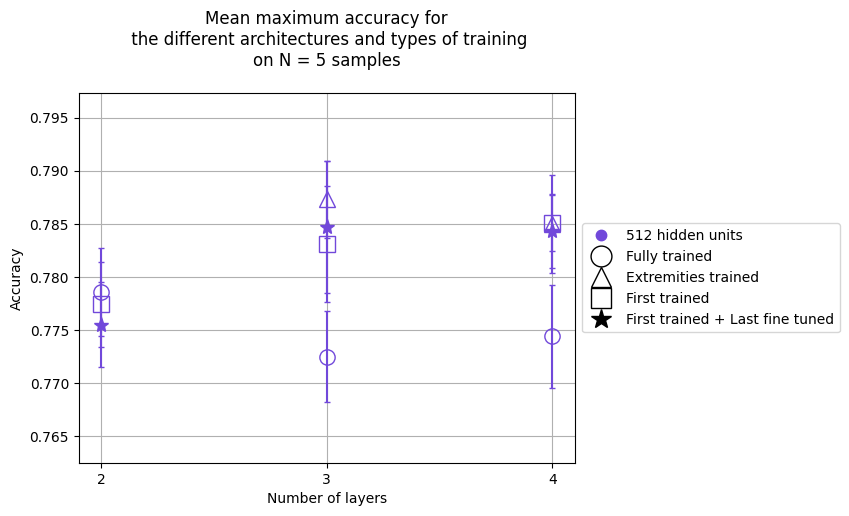

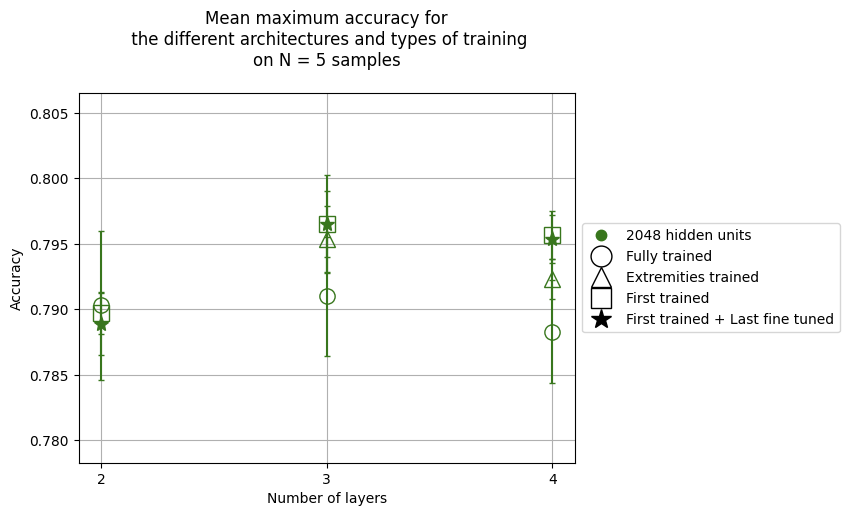

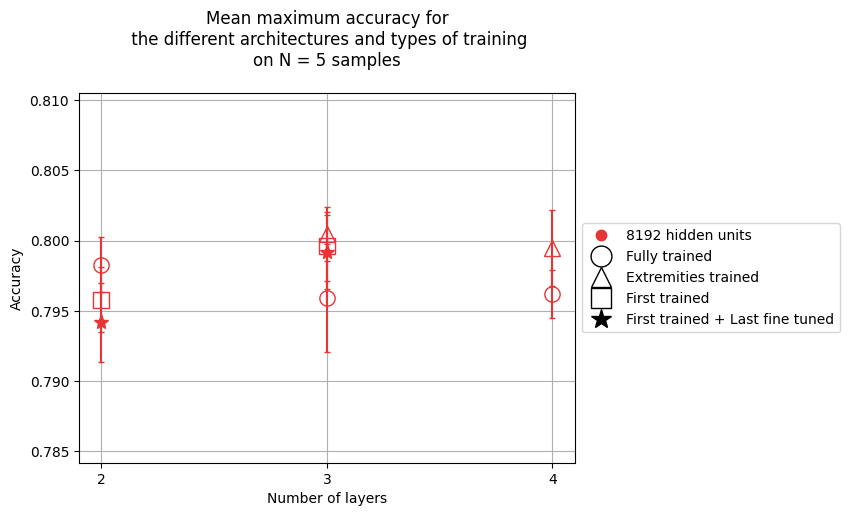

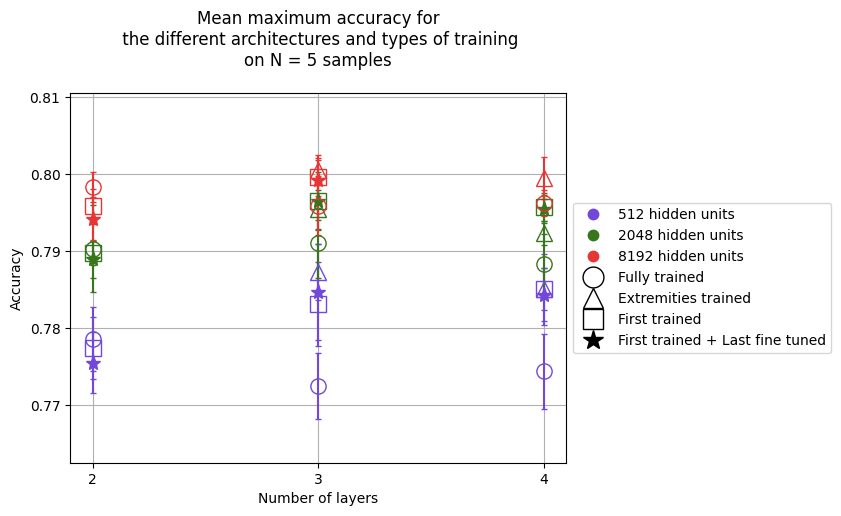

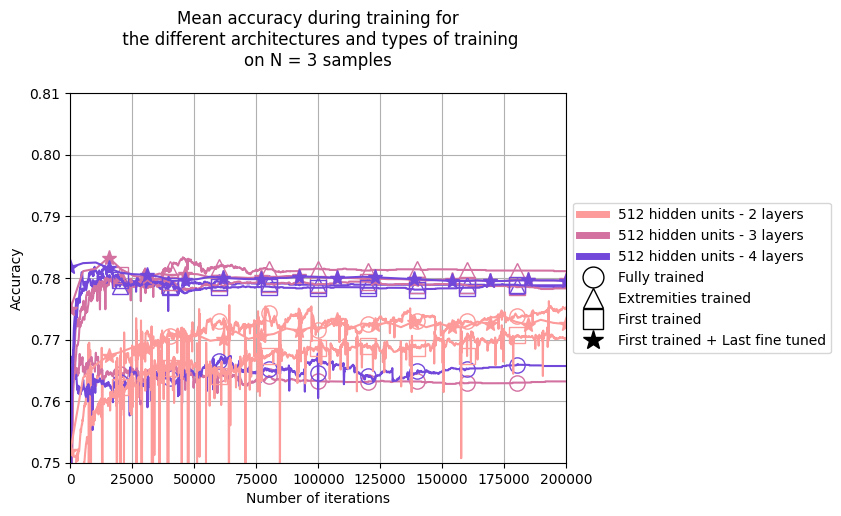

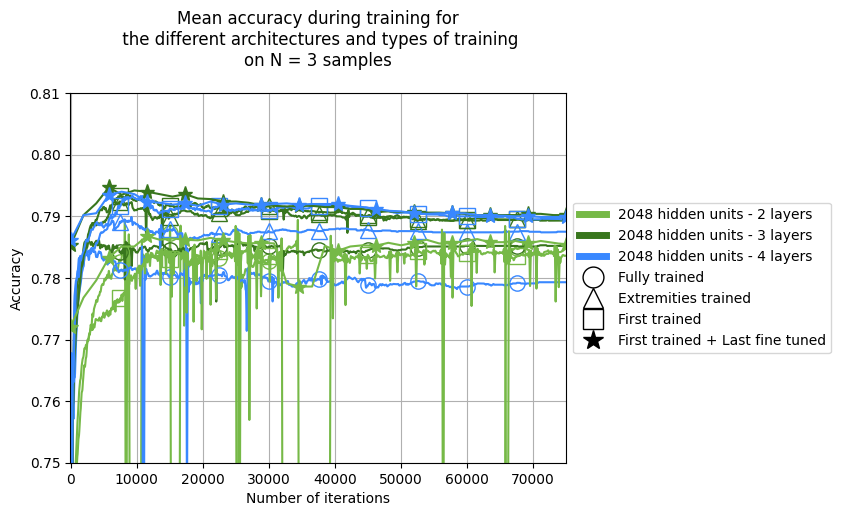

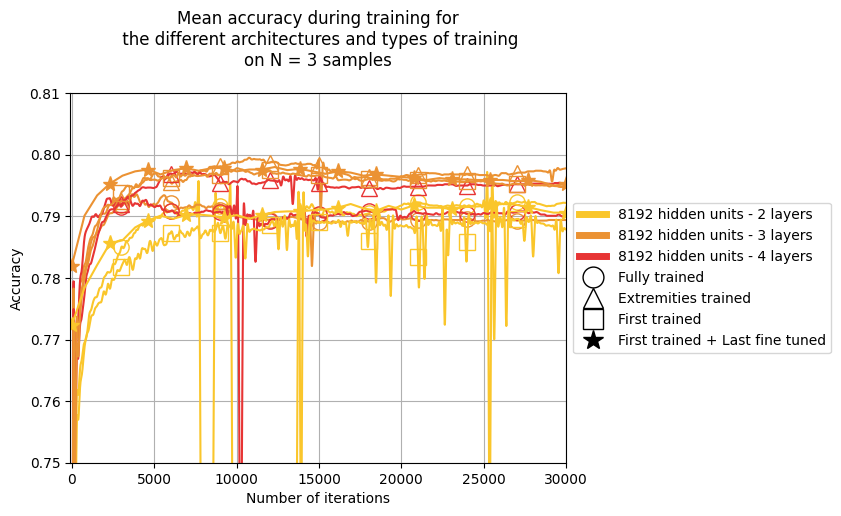

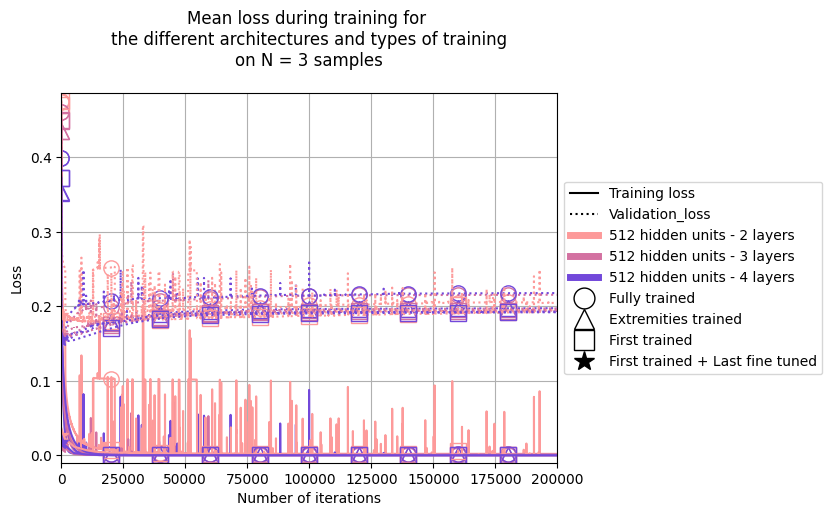

In [94]:
##### 08/07 - Statistical plots on CIFAR-10 : car-plane #####

date = '09_07_25'

dataset = 'elk-horse'

save_path = 'Post-processing/14_07_25/'
save_path_convergence_speed = save_path + 'Convergence speed/Dataset_' + dataset + '_statistical_results/'
save_path_normalized_convergence_speed = save_path + 'Normalized convergence speed/Dataset_' + dataset + '_statistical_results/'
save_path_max_accuracy = save_path + 'Maximum accuracy/Dataset_' + dataset + '_statistical_results/'
save_path_accuracy_trajectory = save_path + 'Accuracy trajectory/Dataset_' + dataset + '_statistical_results/'
save_path_loss_trajectory = save_path + 'Loss trajectory/Dataset_' + dataset + '_statistical_results/'

os.makedirs(save_path_convergence_speed, exist_ok=True)
os.makedirs(save_path_normalized_convergence_speed, exist_ok=True)
os.makedirs(save_path_max_accuracy, exist_ok=True)
os.makedirs(save_path_accuracy_trajectory, exist_ok=True)
os.makedirs(save_path_loss_trajectory, exist_ok=True)


# Plot the performances

model_ref_1_multi_save = load_multi_saves_data_dictionnary("CIFAR10_torch_model_(1024+512.1+1)_" + dataset, date)
model_1_multi_save = load_multi_saves_data_dictionnary("CIFAR10_torch_model_(1024+512.2+1)_" + dataset, date)
model_2_multi_save = load_multi_saves_data_dictionnary("CIFAR10_torch_model_(1024+512.3+1)_" + dataset, date)
model_3_multi_save = load_multi_saves_data_dictionnary("CIFAR10_torch_model_(1024+512-512.1+1)_" + dataset, date)
model_4_multi_save = load_multi_saves_data_dictionnary("CIFAR10_torch_model_(1024+512-512.2+1)_" + dataset, date)
model_5_multi_save = load_multi_saves_data_dictionnary("CIFAR10_torch_model_(1024+512-512.0-1)_" + dataset, date)
model_6_multi_save = load_multi_saves_data_dictionnary("CIFAR10_torch_model_(1024+512-512.1-1)_" + dataset, date)
model_7_multi_save = load_multi_saves_data_dictionnary("CIFAR10_torch_model_(1024+512-512.2-1)_" + dataset, date)

model_ref_2_multi_save = load_multi_saves_data_dictionnary("CIFAR10_torch_model_(1024+2048.1+1)_" + dataset, date)
model_8_multi_save = load_multi_saves_data_dictionnary("CIFAR10_torch_model_(1024+2048.2+1)_" + dataset, date)
model_9_multi_save = load_multi_saves_data_dictionnary("CIFAR10_torch_model_(1024+2048.3+1)_" + dataset, date)
model_10_multi_save = load_multi_saves_data_dictionnary("CIFAR10_torch_model_(1024+2048-2048.1+1)_" + dataset, date)
model_11_multi_save = load_multi_saves_data_dictionnary("CIFAR10_torch_model_(1024+2048-2048.2+1)_" + dataset, date)
model_12_multi_save = load_multi_saves_data_dictionnary("CIFAR10_torch_model_(1024+2048-2048.0-1)_" + dataset, date)
model_13_multi_save = load_multi_saves_data_dictionnary("CIFAR10_torch_model_(1024+2048-2048.1-1)_" + dataset, date)
model_14_multi_save = load_multi_saves_data_dictionnary("CIFAR10_torch_model_(1024+2048-2048.2-1)_" + dataset, date)

model_ref_3_multi_save = load_multi_saves_data_dictionnary("CIFAR10_torch_model_(1024+8192.1+1)_" + dataset, date)
model_15_multi_save = load_multi_saves_data_dictionnary("CIFAR10_torch_model_(1024+8192.2+1)_" + dataset, date)
model_16_multi_save = load_multi_saves_data_dictionnary("CIFAR10_torch_model_(1024+8192.3+1)_" + dataset, date)
model_17_multi_save = load_multi_saves_data_dictionnary("CIFAR10_torch_model_(1024+8192-8192.1+1)_" + dataset, date)
model_18_multi_save = load_multi_saves_data_dictionnary("CIFAR10_torch_model_(1024+8192-8192.2+1)_" + dataset, date)
model_19_multi_save = load_multi_saves_data_dictionnary("CIFAR10_torch_model_(1024+8192-8192.0-1)_" + dataset, date)
model_20_multi_save = load_multi_saves_data_dictionnary("CIFAR10_torch_model_(1024+8192-8192.1-1)_" + dataset, date)
# model_21_multi_save = load_multi_saves_data_dictionnary("CIFAR10_torch_model_(1024+8192-8192.2-1)_" + dataset, date)

model_ref_1 = convert_to_statistical_data_dictionnary(model_ref_1_multi_save)
model_1 = convert_to_statistical_data_dictionnary(model_1_multi_save)
model_2 = convert_to_statistical_data_dictionnary(model_2_multi_save)
model_3 = convert_to_statistical_data_dictionnary(model_3_multi_save)
model_4 = convert_to_statistical_data_dictionnary(model_4_multi_save)
model_5 = convert_to_statistical_data_dictionnary(model_5_multi_save)
model_6 = convert_to_statistical_data_dictionnary(model_6_multi_save)
model_7 = convert_to_statistical_data_dictionnary(model_7_multi_save)

model_ref_2 = convert_to_statistical_data_dictionnary(model_ref_2_multi_save)
model_8 = convert_to_statistical_data_dictionnary(model_8_multi_save)
model_9 = convert_to_statistical_data_dictionnary(model_9_multi_save)
model_10 = convert_to_statistical_data_dictionnary(model_10_multi_save)
model_11 = convert_to_statistical_data_dictionnary(model_11_multi_save)
model_12 = convert_to_statistical_data_dictionnary(model_12_multi_save)
model_13 = convert_to_statistical_data_dictionnary(model_13_multi_save)
model_14 = convert_to_statistical_data_dictionnary(model_14_multi_save)

model_ref_3 = convert_to_statistical_data_dictionnary(model_ref_3_multi_save)
model_15 = convert_to_statistical_data_dictionnary(model_15_multi_save)
model_16 = convert_to_statistical_data_dictionnary(model_16_multi_save)
model_17 = convert_to_statistical_data_dictionnary(model_17_multi_save)
model_18 = convert_to_statistical_data_dictionnary(model_18_multi_save)
model_19 = convert_to_statistical_data_dictionnary(model_19_multi_save)
model_20 = convert_to_statistical_data_dictionnary(model_20_multi_save)
# model_21 = convert_to_statistical_data_dictionnary(model_21_multi_save)

curve_dictionnary_512hu_multi_save = {'512 hidden units' : 
                        {'Fully trained' : {'2 layers' : model_ref_1_multi_save, '3 layers' : model_1_multi_save, '4 layers' : model_2_multi_save},
                        'Extremities trained': {'3 layers' : model_3_multi_save, '4 layers' : model_4_multi_save},
                        'First trained': {'2 layers' : model_5_multi_save, '3 layers' : model_6_multi_save, '4 layers' : model_7_multi_save},
                        'First trained + Last fine tuned' : {'2 layers' : model_5_multi_save, '3 layers' : model_6_multi_save, '4 layers' : model_7_multi_save}
                         }}

curve_dictionnary_512hu= {'512 hidden units' : 
                        { 'Fully trained' : {'2 layers' : model_ref_1, '3 layers' : model_1, '4 layers' : model_2},
                        'Extremities trained': {'3 layers' : model_3, '4 layers' : model_4},
                        'First trained': {'2 layers' : model_5, '3 layers' : model_6, '4 layers' : model_7},
                        'First trained + Last fine tuned' : {'2 layers' : model_5, '3 layers' : model_6, '4 layers' : model_7}
                         }}

curve_dictionnary_2048hu_multi_save = {'2048 hidden units' : 
                        {'Fully trained' : {'2 layers' : model_ref_2_multi_save, '3 layers' : model_8_multi_save, '4 layers' : model_9_multi_save},
                        'Extremities trained': {'3 layers' : model_10_multi_save, '4 layers' : model_11_multi_save},
                        'First trained': {'2 layers' : model_12_multi_save, '3 layers' : model_13_multi_save, '4 layers' : model_14_multi_save},
                        'First trained + Last fine tuned' : {'2 layers' : model_12_multi_save, '3 layers' : model_13_multi_save, '4 layers' : model_14_multi_save}
                         }}

curve_dictionnary_2048hu = {'2048 hidden units' : 
                        {'Fully trained' : {'2 layers' : model_ref_2, '3 layers' : model_8, '4 layers' : model_9},
                        'Extremities trained': {'3 layers' : model_10, '4 layers' : model_11},
                        'First trained': {'2 layers' : model_12, '3 layers' : model_13, '4 layers' : model_14},
                        'First trained + Last fine tuned' : {'2 layers' : model_12, '3 layers' : model_13, '4 layers' : model_14}
                         }}

curve_dictionnary_8192hu_multi_save = {'8192 hidden units' : 
                        {'Fully trained' : {'2 layers' : model_ref_3_multi_save, '3 layers' : model_15_multi_save, '4 layers' : model_16_multi_save},
                        'Extremities trained': {'3 layers' : model_17_multi_save, '4 layers' : model_18_multi_save},
                        'First trained': {'2 layers' : model_19_multi_save, '3 layers' : model_20_multi_save},#, '4 layers' : model_21_multi_save},
                        'First trained + Last fine tuned' : {'2 layers' : model_19_multi_save, '3 layers' : model_20_multi_save}#, '4 layers' : model_21_multi_save}
                         }}

curve_dictionnary_8192hu = {'8192 hidden units' : 
                        {'Fully trained' : {'2 layers' : model_ref_3, '3 layers' : model_15, '4 layers' : model_16},
                        'Extremities trained': {'3 layers' : model_17, '4 layers' : model_18},
                        'First trained': {'2 layers' : model_19, '3 layers' : model_20},# '4 layers' : model_21},
                        'First trained + Last fine tuned' : {'2 layers' : model_19, '3 layers' : model_20}#, '4 layers' : model_21}
                         }}


curve_dictionnary = curve_dictionnary_512hu_multi_save | curve_dictionnary_2048hu_multi_save | curve_dictionnary_8192hu_multi_save

line_color_list = {'8192 hidden units' : {'2 layers' : 'gold', '3 layers' : 'orange', '4 layers' : 'red'},
                   '2048 hidden units' : {'2 layers' : 'olive', '3 layers' : 'cyan', '4 layers' : 'blue'}, 
                   '512 hidden units' : {'2 layers' : 'pink', '3 layers' : 'magenta', '4 layers' : 'purple'}}

color_list_1 = {'8192 hidden units' : '#e73434', 
              '2048 hidden units' : '#38761d', 
              '512 hidden units' : "#7148daff"
              }

color_list_2 = {'8192 hidden units' : {'2 layers' : "#fac62b", '3 layers' : "#eb9233", '4 layers' : "#e73434"},
                   '2048 hidden units' : {'2 layers' : "#76b947", '3 layers' : '#38761d', '4 layers' : "#3988ff"}, 
                   '512 hidden units' : {'2 layers' : "#fd9a9a", '3 layers' : "#d371a1", '4 layers' : "#7248da"}}

marker_list = {'Reference' : 'D', 'Fully trained' : 'o', 'Extremities trained' : '^', 'First trained' : 's', 'First trained + Last fine tuned' : '*'}

y_lim = [0.76, 0.80]
x_lim_2 = [0, 30e3]
y_lim_2 = [0.72, 0.81]
x_lim_3 = [0, 15e3]
y_lim_3 = [0.72, 0.81]


statistical_max_accuracy_plot(curve_dictionnary_512hu_multi_save, color_list_1, marker_list, save_file=True, save_path=save_path_max_accuracy)
statistical_max_accuracy_plot(curve_dictionnary_2048hu_multi_save, color_list_1, marker_list, save_file=True, save_path=save_path_max_accuracy)
statistical_max_accuracy_plot(curve_dictionnary_8192hu_multi_save, color_list_1, marker_list, save_file=True, save_path=save_path_max_accuracy)
statistical_max_accuracy_plot(curve_dictionnary, color_list_1, marker_list, save_file=True, save_path=save_path_max_accuracy)

statistical_accuracy_trajectory_plot(curve_dictionnary_512hu, n_saves=3, color_list=color_list_2, marker_list=marker_list, y_lim=y_lim, save=True, save_path=save_path_accuracy_trajectory, save_name_peculiarity=dataset + '_512hu')
statistical_accuracy_trajectory_plot(curve_dictionnary_2048hu, n_saves=3, color_list=color_list_2, marker_list=marker_list, y_lim=y_lim, save=True, save_path=save_path_accuracy_trajectory, save_name_peculiarity=dataset + '_512hu')
statistical_accuracy_trajectory_plot(curve_dictionnary_8192hu, n_saves=3, color_list=color_list_2, marker_list=marker_list, y_lim=y_lim, save=True, save_path=save_path_accuracy_trajectory, save_name_peculiarity=dataset + '_512hu')

statistical_loss_trajectory_plot(curve_dictionnary_512hu, n_saves=3, color_list=color_list_2, marker_list=marker_list, save=True, save_path=save_path_accuracy_trajectory, save_name_peculiarity=dataset + '_512hu')


In [40]:
def layers_covariances(weight_1, bias_1, weight_2, bias_2, inputs, deep_layer_inputs, type, layer_rank):
    if layer_rank==1:    
        
        if type == 'preactivation':
            layer_1, layer_2 = torch.cat([weight_1,bias_1], dim=1), torch.cat([weight_2,bias_2], dim=1)
            norm = torch.einsum('qnt,pnt->qpt', layer_1, layer_1).norm(dim=(0,1))  # shape (1,n,t)
            covariance_matrix = torch.einsum('qnt,pnt->qpt', layer_1, layer_2) # shape (d1,d1, t)
        elif type == 'hidden' :
            layer_1 = torch.relu(torch.einsum('pdt,nd->pnt', weight_1, inputs) + bias_1) # shape (d1, n)
            layer_2 = torch.relu(torch.einsum('pdt,nd->pnt', weight_2, inputs) + bias_2) # shape (d1, n)
            norm = torch.einsum('qnt,pnt->qpt', layer_1, layer_1).norm(dim=(0,1))  # shape (1,n,t)
            covariance_matrix = torch.einsum('qnt,pnt->qpt', layer_1, layer_2) # shape (d1,d1, t)
    
    else :
        
        if type == 'preactivation':
            layer_1 = torch.einsum('qpt,pnt->qnt', weight_1, deep_layer_inputs[0]) + bias_1 # shape (d1, n)
            layer_2 = torch.einsum('qpt,pnt->qnt', weight_2, deep_layer_inputs[1]) + bias_2 # shape (d1, n)   
            norm = torch.einsum('qnt,pnt->qpt', layer_1, layer_1).norm(dim=(0,1))  # shape (1,n,t)
            covariance_matrix = torch.einsum('qnt,pnt->qpt', layer_1, layer_2) # shape (d1,d1, t)    
        elif type == 'hidden' :
            layer_1 = torch.relu(torch.einsum('qpt,pnt->qnt', weight_1, deep_layer_inputs[0]) + bias_1) # shape (d1, n, t)
            layer_2 = torch.relu(torch.einsum('qpt,pnt->qnt', weight_2, deep_layer_inputs[1]) + bias_2) # shape (d1, n, t)
            norm = torch.einsum('qnt,pnt->qpt', layer_1, layer_1).norm(dim=(0,1)) #layer_1.norm(dim=(0,1))  # shape (1)
            covariance_matrix = torch.einsum('qnt,pnt->qpt', layer_1, layer_2) # shape (d1,d1,t)
    
    likelyhood = (covariance_matrix / norm).norm(dim=(0,1)) # shape (t)
    return likelyhood, layer_1, layer_2


def representations_likelyhood_trajectories(model_1, model_2, x_validation, save_path, architecture, add_to_title=''):
    x_validation = x_validation.to(device)
    min_time = np.min([len(model_1['layers trajectories'][1]), len(model_2['layers trajectories'][1])])
    print(min_time)
    
    overlap_dico = {'likelyhood_trajectory' : 
        {'data' : {1 : {'preactivation' : [], 'hidden' : []}, 2 : {'preactivation' : [], 'hidden' : []}}, 
         'plot' : {'title' : 'Frobenius norm of the covariance matrix between the representations\nof ' + add_to_title,
                   'xlabel' : 'Iteration N', 'ylabel' : r"$\mathbb{E}_{\bf{x}}[\cos(\theta)]$"}},
                    'likelyhood_variance_trajectory' :
        {'data' : {1 : {'preactivation' : [], 'hidden' : []}, 2 : {'preactivation' : [], 'hidden' : []}},
         'plot' : {'title' : 'Variance of the likelyhood between the representations\nof ' + add_to_title,
                   'xlabel' : 'Iteration N', 'ylabel' : r"Var [$\cos(\theta)$]"}}}

    likelyhood = {1 : {'preactivation' : [], 'hidden' : []}, 2 : {'preactivation' : [], 'hidden' : []}}
    color_list = {1 : {'preactivation' : 'blue', 'hidden' : 'green'}, 2 : {'preactivation' : 'orange', 'hidden' : 'red'}}

    label_list = {1 : {'preactivation' : r"$\frac{W_1.W_1'^{\top}}{\|W_1\|_F}$", 'hidden' : r"$(\sigma(W_1.x^{\top}))^{\top}.(\sigma(W_1'.x^{\top}))$"},
                  2 : {'preactivation' : r"$(W_2\sigma(W_1.x^{\top}))^{\top}.(W_2'\sigma(W_1'.x^{\top}))$", 'hidden' : r"$(\sigma(W_2\sigma(W_1.x^{\top})))^{\top}.(\sigma(W_2'\sigma(W_1'.x^{\top})))$"}}
    for first_layer_params_1, first_layer_params_2, second_layer_params_1, second_layer_params_2 in zip(model_1['layers trajectories'][1][:min_time],
                                                                                                        model_2['layers trajectories'][1][:min_time], 
                                                                                                        model_1['layers trajectories'][2][:min_time],
                                                                                                        model_2['layers trajectories'][2][:min_time]) :
        
        weights = {'model 1' : {1 : first_layer_params_1[:,:-1,:].to(device), 2 : second_layer_params_1[:,:-1,:].to(device)}, 
                   'model 2' : {1 : first_layer_params_2[:,:-1,:].to(device), 2 : second_layer_params_2[:,:-1,:].to(device)}}
        biases = {'model 1' : {1 : first_layer_params_1[:,-1,:].to(device).unsqueeze(1), 2 : second_layer_params_1[:,-1,:].to(device).unsqueeze(1)}, 
                'model 2' : {1 : first_layer_params_2[:,-1,:].to(device).unsqueeze(1), 2 : second_layer_params_2[:,-1,:].to(device).unsqueeze(1)}}

        for layer_rank in likelyhood :
            if layer_rank == 1:
                deep_layer_inputs = []
                likelyhood[layer_rank]['preactivation'] = layers_covariances(
                    weights['model 1'][layer_rank], biases['model 1'][layer_rank], weights['model 2'][layer_rank], 
                    biases['model 2'][layer_rank], x_validation, deep_layer_inputs, type='preactivation', layer_rank=layer_rank)[0]

                likelyhood[layer_rank]['hidden'], layer_1, layer_2 = layers_covariances(
                    weights['model 1'][layer_rank], biases['model 1'][layer_rank], weights['model 2'][layer_rank],
                    biases['model 2'][layer_rank], x_validation, deep_layer_inputs, type='hidden', layer_rank=layer_rank)

            else :
                deep_layer_inputs = [layer_1, layer_2]
                likelyhood[layer_rank]['preactivation'] = layers_covariances(
                    weights['model 1'][layer_rank], biases['model 1'][layer_rank], weights['model 2'][layer_rank], 
                    biases['model 2'][layer_rank], x_valid, deep_layer_inputs, type='preactivation', layer_rank=layer_rank)[0]

                likelyhood[layer_rank]['hidden'], layer_1, layer_2 = layers_covariances(
                    weights['model 1'][layer_rank], biases['model 1'][layer_rank], weights['model 2'][layer_rank],
                    biases['model 2'][layer_rank], x_valid, deep_layer_inputs, type='hidden', layer_rank=layer_rank)
            
        save_interval_size = likelyhood[layer_rank]['preactivation'].shape[0]
        # Register overlap information
        for t in range (save_interval_size): 
            for layer_rank in overlap_dico['likelyhood_trajectory']['data'] :
                for type_of_layer in overlap_dico['likelyhood_trajectory']['data'][layer_rank] :
                    # First layer preactivation 
                    overlap_dico['likelyhood_trajectory']['data'][layer_rank][type_of_layer].append(likelyhood[layer_rank][type_of_layer][t].cpu())
                    overlap_dico['likelyhood_variance_trajectory']['data'][layer_rank][type_of_layer].append((torch.sqrt((likelyhood[layer_rank][type_of_layer][t] - (likelyhood[layer_rank][type_of_layer][:].mean()))**2).mean()).cpu())
    
    # Plot datas
    T = np.linspace(0, (min_time*save_interval_size+1)*10, min_time*save_interval_size+1)
    for curve in overlap_dico :
        legend_elements = []
        for layer_rank in overlap_dico[curve]['data']:
            for type_of_layer in overlap_dico[curve]['data'][layer_rank]:
                plt.plot(T, overlap_dico[curve]['data'][layer_rank][type_of_layer], color=color_list[layer_rank][type_of_layer])
                legend_elements += [Line2D([0], [0], color=color_list[layer_rank][type_of_layer], linewidth=5, label = label_list[layer_rank][type_of_layer])]                    
        legend = plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
        for handle in legend.legend_handles:
            handle.set_markersize(15)
        plt.title(overlap_dico[curve]['plot']['title'], pad=20)
        plt.xlabel(overlap_dico[curve]['plot']['xlabel'])
        plt.ylabel(overlap_dico[curve]['plot']['ylabel'])
        # if curve == 'likelyhood_trajectory':
        #     plt.ylim([-0.05,0.5])
        plt.grid()
        os.makedirs(save_path + '/' + architecture, exist_ok=True) 
        plt.savefig(save_path + '/' + architecture + '/' + curve + '.png', bbox_inches='tight')
        plt.savefig(save_path + '/' + architecture + '/' + curve + '.svg', bbox_inches='tight')
        plt.show()

    return overlap_dico

In [59]:
def principal_angles_representation(activation_1, activation_2):
    """
    Compare activations of two models via principal angles.

    activation_1 : (N, d1) torch.Tensor
    activation_2 : (N, d2) torch.Tensor

    Returns:
        angles_degrees : (min(d1, d2),) torch.Tensor
    """


    # Move to CPU for QR decomposition
    activation_1 = activation_1.cpu()
    activation_2 = activation_2.cpu()

    activation_1 = activation_1 - activation_1.mean(dim=0, keepdim=True)
    activation_2 = activation_2 - activation_2.mean(dim=0, keepdim=True)
    index = 0
    for t in range(activation_1.shape[2]):
        Q1, _ = torch.linalg.qr(activation_1[:,:,t])
        Q2, _ = torch.linalg.qr(activation_2[:,:,t])

        M = torch.matmul(Q1.T, Q2)
        _, S, _ = torch.linalg.svd(M)

        S = torch.clamp(S, -1.0, 1.0)
        angles =  S #torch.arccos(S) * (180.0 / np.pi)
        if index == 0 :
            angles_tensor = angles.unsqueeze(1)
        else: 
            angles_tensor = torch.cat([angles_tensor,angles.unsqueeze(1)], dim=1) 
        index+=1
    return angles_tensor.to(device)


def representation_overlap_trajectories(model_1, model_2, x_validation, save_path, architecture, add_to_title=''):
    x_validation = x_validation.to(device)
    min_time = np.min([len(model_1['layers trajectories'][1]), len(model_2['layers trajectories'][1])])
    print(min_time)
    
    overlap_dico = {'normalized_cross_scalar_product_matrix_trace_trajectory' : 
        {'data' : {1 : {'preactivation' : [], 'hidden' : []}, 2 : {'preactivation' : [], 'hidden' : []}}, 
         'plot' : {'title' : 'Expectation of the cosine similarity between the representations\nof ' + add_to_title,
                   'xlabel' : 'Iteration N', 'ylabel' : r"$\mathbb{E}_{\bf{x}}[\cos(\theta)]$"}},
                    'cross_scalar_product_matrix_trace_variance_trajectory' :
        {'data' : {1 : {'preactivation' : [], 'hidden' : []}, 2 : {'preactivation' : [], 'hidden' : []}},
         'plot' : {'title' : 'Variance of the cosine similarity between the representations\nof ' + add_to_title,
                   'xlabel' : 'Iteration N', 'ylabel' : r"Var [$\cos(\theta)$]"}},
                    'arccos_product_matrix_trace_trajectory' :
        {'data' : {1 : {'preactivation' : [], 'hidden' : []}, 2 : {'preactivation' : [], 'hidden' : []}},
         'plot' : {'title' : 'Mean angle between the representations\nof ' + add_to_title,
                   'xlabel' : 'Iteration N', 'ylabel' : r"$\theta$"}},
                    'max_normalized_cross_scalar_product_matrix_trace_trajectory' :
        {'data' : {1 : {'preactivation' : [], 'hidden' : []}, 2 : {'preactivation' : [], 'hidden' : []}},
         'plot' : {'title' : 'Maximum cosine similarity between the representations\n of ' + add_to_title,
                   'xlabel' : 'Iteration N', 'ylabel' : r"Max ($[\cos(\theta))$]"}},
                   'mean_prinicpal_angle_trajectory' : 
        {'data' : {1 : {'preactivation' : [], 'hidden' : []}, 2 : {'preactivation' : [], 'hidden' : []}}, 
         'plot' : {'title' : 'Principal angle between the representations\nof ' + add_to_title,
                   'xlabel' : 'Iteration N', 'ylabel' : r"$\mathbb{E}_{\bf{x}}[\cos(\theta)]$"}},
                    'max_prinicpal_angle_trajectory' : 
        {'data' : {1 : {'preactivation' : [], 'hidden' : []}, 2 : {'preactivation' : [], 'hidden' : []}}, 
         'plot' : {'title' : 'Principal angle between the representations\nof ' + add_to_title,
                   'xlabel' : 'Iteration N', 'ylabel' : r"$\mathbb{E}_{\bf{x}}[\cos(\theta)]$"}}}

    normalized_cross_scalar_product_matrix = {1 : {'preactivation' : [], 'hidden' : []}, 2 : {'preactivation' : [], 'hidden' : []}}
    principal_angles_dico = {1 : {'preactivation' : [], 'hidden' : []}, 2 : {'preactivation' : [], 'hidden' : []}}
    color_list = {1 : {'preactivation' : 'blue', 'hidden' : 'green'}, 2 : {'preactivation' : 'orange', 'hidden' : 'red'}}

    label_list = {1 : {'preactivation' : r"$(W_1.x^{\top})^{\top}.(W_1'.x^{\top})$", 'hidden' : r"$(\sigma(W_1.x^{\top}))^{\top}.(\sigma(W_1'.x^{\top}))$"},
                  2 : {'preactivation' : r"$(W_2\sigma(W_1.x^{\top}))^{\top}.(W_2'\sigma(W_1'.x^{\top}))$", 'hidden' : r"$(\sigma(W_2\sigma(W_1.x^{\top})))^{\top}.(\sigma(W_2'\sigma(W_1'.x^{\top})))$"}}
    for first_layer_params_1, first_layer_params_2, second_layer_params_1, second_layer_params_2 in zip(model_1['layers trajectories'][1][:min_time],
                                                                                                        model_2['layers trajectories'][1][:min_time], 
                                                                                                        model_1['layers trajectories'][2][:min_time],
                                                                                                        model_2['layers trajectories'][2][:min_time]) :
        
        weights = {'model 1' : {1 : first_layer_params_1[:,:-1,:].to(device), 2 : second_layer_params_1[:,:-1,:].to(device)}, 
                   'model 2' : {1 : first_layer_params_2[:,:-1,:].to(device), 2 : second_layer_params_2[:,:-1,:].to(device)}}
        biases = {'model 1' : {1 : first_layer_params_1[:,-1,:].to(device).unsqueeze(1), 2 : second_layer_params_1[:,-1,:].to(device).unsqueeze(1)}, 
                'model 2' : {1 : first_layer_params_2[:,-1,:].to(device).unsqueeze(1), 2 : second_layer_params_2[:,-1,:].to(device).unsqueeze(1)}}

        for layer_rank in normalized_cross_scalar_product_matrix :
            if layer_rank == 1:
                deep_layer_inputs = []
                normalized_cross_scalar_product_matrix[layer_rank]['preactivation'], layer_1, layer_2 = layer_representation(
                    weights['model 1'][layer_rank], biases['model 1'][layer_rank], weights['model 2'][layer_rank], 
                    biases['model 2'][layer_rank], x_validation, deep_layer_inputs, type='preactivation', layer_rank=layer_rank)
                principal_angles_dico[layer_rank]['preactivation'] = principal_angles_representation(layer_1, layer_2)

                normalized_cross_scalar_product_matrix[layer_rank]['hidden'], layer_1, layer_2 = layer_representation(
                    weights['model 1'][layer_rank], biases['model 1'][layer_rank], weights['model 2'][layer_rank],
                    biases['model 2'][layer_rank], x_validation, deep_layer_inputs, type='hidden', layer_rank=layer_rank)
                principal_angles_dico[layer_rank]['hidden'] = principal_angles_representation(layer_1, layer_2)

            else :
                deep_layer_inputs = [layer_1, layer_2]
                normalized_cross_scalar_product_matrix[layer_rank]['preactivation'] = layer_representation(
                    weights['model 1'][layer_rank], biases['model 1'][layer_rank], weights['model 2'][layer_rank], 
                    biases['model 2'][layer_rank], x_valid, deep_layer_inputs, type='preactivation', layer_rank=layer_rank)[0]
                principal_angles_dico[layer_rank]['preactivation'] = principal_angles_representation(layer_1, layer_2)

                normalized_cross_scalar_product_matrix[layer_rank]['hidden'], layer_1, layer_2 = layer_representation(
                    weights['model 1'][layer_rank], biases['model 1'][layer_rank], weights['model 2'][layer_rank],
                    biases['model 2'][layer_rank], x_valid, deep_layer_inputs, type='hidden', layer_rank=layer_rank)
                principal_angles_dico[layer_rank]['hidden'] = principal_angles_representation(layer_1, layer_2)

        save_interval_size = normalized_cross_scalar_product_matrix[layer_rank]['preactivation'].shape[2]
        # Register overlap information
        for t in range (save_interval_size): 
            for layer_rank in overlap_dico['normalized_cross_scalar_product_matrix_trace_trajectory']['data'] :
                for type_of_layer in overlap_dico['normalized_cross_scalar_product_matrix_trace_trajectory']['data'][layer_rank] :
                    # First layer preactivation 
                    overlap_dico['normalized_cross_scalar_product_matrix_trace_trajectory']['data'][layer_rank][type_of_layer].append(normalized_cross_scalar_product_matrix[layer_rank][type_of_layer][:,:,t].trace().cpu()/x_validation.shape[0])
                    overlap_dico['max_normalized_cross_scalar_product_matrix_trace_trajectory']['data'][layer_rank][type_of_layer].append(normalized_cross_scalar_product_matrix[layer_rank][type_of_layer][:,:,t].max().cpu()) 
                    overlap_dico['arccos_product_matrix_trace_trajectory']['data'][layer_rank][type_of_layer].append((180/np.pi)*np.arccos(normalized_cross_scalar_product_matrix[layer_rank][type_of_layer][:,:,t].trace().cpu()/x_validation.shape[0]))
                    overlap_dico['cross_scalar_product_matrix_trace_variance_trajectory']['data'][layer_rank][type_of_layer].append((torch.sqrt((normalized_cross_scalar_product_matrix[layer_rank][type_of_layer][:,:,t] - (normalized_cross_scalar_product_matrix[layer_rank][type_of_layer][:,:,t].trace()/x_validation.shape[0]))**2).mean()).cpu())
                    overlap_dico['mean_prinicpal_angle_trajectory']['data'][layer_rank][type_of_layer].append(principal_angles_dico[layer_rank][type_of_layer].mean().cpu())
                    overlap_dico['max_prinicpal_angle_trajectory']['data'][layer_rank][type_of_layer].append(principal_angles_dico[layer_rank][type_of_layer].max().cpu())

    # Plot datas
    
    T = np.linspace(0, (min_time*save_interval_size+1)*10, min_time*save_interval_size+1)
    for curve in overlap_dico :
        legend_elements = []
        for layer_rank in overlap_dico[curve]['data']:
            for type_of_layer in overlap_dico[curve]['data'][layer_rank]:
                plt.plot(T[:1000], overlap_dico[curve]['data'][layer_rank][type_of_layer][:1000], color=color_list[layer_rank][type_of_layer])
                legend_elements += [Line2D([0], [0], color=color_list[layer_rank][type_of_layer], linewidth=5, label = label_list[layer_rank][type_of_layer])]                    
        legend = plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
        for handle in legend.legend_handles:
            handle.set_markersize(15)
        plt.title(overlap_dico[curve]['plot']['title'], pad=20)
        plt.xlabel(overlap_dico[curve]['plot']['xlabel'])
        plt.ylabel(overlap_dico[curve]['plot']['ylabel'])
        if curve == 'normalized_cross_scalar_product_matrix_trace_trajectory' or curve == 'max_normalized_cross_scalar_product_matrix_trace_trajectory':
            plt.ylim([-0.05,0.5])
        elif curve == 'arccos_product_matrix_trace_trajectory':
            plt.ylim([60,95])
        plt.grid()
        os.makedirs(save_path + '/' + architecture, exist_ok=True) 
        plt.savefig(save_path + '/' + architecture + '/' + curve + '.png', bbox_inches='tight')
        plt.savefig(save_path + '/' + architecture + '/' + curve + '.svg', bbox_inches='tight')
        plt.show()

    return overlap_dico

torch.Size([50000, 10]) torch.Size([10000, 10])


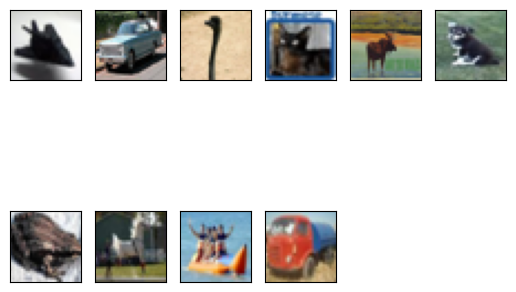

torch.Size([10000, 32, 32, 3]) torch.Size([10000, 1]) tensor([[0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.]]) torch.Size([2000, 32, 32, 3]) torch.Size([2000, 1])


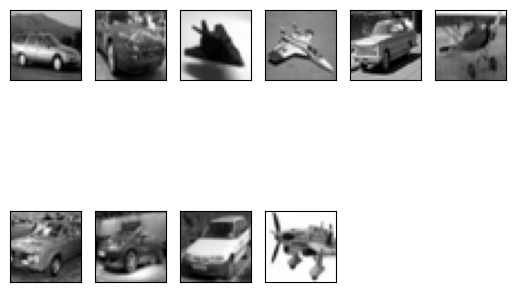

torch.Size([10000, 1024]) torch.Size([2000, 1024])


In [60]:
dtype = torch.float32

transform_data = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) # Apply the (x - mean)/var operation on the components of the data # if x is in [0,1] then Normalise(x) is in [-1,1] # is applied on the three channels RGB
])

# Data import
dtype = torch.float32
trainset = torchvision.datasets.CIFAR10(root = './datas', train= True, download = True, transform = transform_data)
validset = torchvision.datasets.CIFAR10(root = './datas', train = False, download = True, transform = transform_data)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 1)

x_train, y_train_raw, x_valid, y_valid_raw = torch.tensor(trainset.data), torch.tensor(trainset.targets), torch.tensor(validset.data), torch.tensor(validset.targets)

# Modification du format des données shape (n_data,1) -> (n_data, n_classes)
y_train = torch.zeros((y_train_raw.shape[0], torch.max(y_train_raw)+1))
for i, y in enumerate(y_train_raw):
    j = int(y.item())
    y_train[i,j] = 1

y_valid = torch.zeros((y_valid_raw.shape[0], torch.max(y_valid_raw)+1))
for i,y in enumerate(y_valid_raw):
    j = int(y.item())
    y_valid[i,j] = 1 
print(y_train.shape, y_valid.shape)

# Binary reduction of the classes # To avoid using softmax, we regroup classes in two classes
class_binary_reduction = True
determination_des_classes = True
black_and_white_images = True

if class_binary_reduction :
    if determination_des_classes :
        # Determination des classes
        class_list = []
        class_index = 0
        for i in range (x_train.shape[0]):
            if y_train[i, class_index] == 1:
                class_list.append(x_train[i])
                class_index += 1
            if len(class_list) == len(y_train[0]):
                break
        for i, image in enumerate(class_list):
            plt.subplot(2, int(len(class_list)/2+1),i+1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
        plt.show()
                
    # classe1 = [0, 1, 8, 9]  # vehicles
    # classe2 = [2, 3, 4, 5]  # animals
    
    # classe1 = [1, 3, 4]  # elk, truck, dog
    # classe2 = [5, 7, 9]  # horse, car, cat

    classe1 = [0]  # elk
    classe2 = [1]  # horse
    
    # Création des masques pour les échantillons appartenant à ces classes
    mask_classe1_train = y_train[:, classe1].sum(dim=1) > 0  # True si appartient à classe1
    mask_classe2_train = y_train[:, classe2].sum(dim=1) > 0  # True si appartient à classe2
    
    mask_classe1_valid = y_valid[:, classe1].sum(dim=1) > 0
    mask_classe2_valid = y_valid[:, classe2].sum(dim=1) > 0
    
    # Filtrage des exemples concernés
    mask_train = torch.logical_or(mask_classe1_train, mask_classe2_train)
    mask_valid = torch.logical_or(mask_classe1_valid, mask_classe2_valid)
    x_train, y_train = x_train[mask_train], y_train[mask_train]
    x_valid, y_valid = x_valid[mask_valid], y_valid[mask_valid]

    # Création du vecteur de labels binaires (1 pour classe1, 0 pour classe2)
    y_train = (y_train[:, classe1].sum(dim=1) > 0).to(dtype).unsqueeze(1)
    y_valid = (y_valid[:, classe1].sum(dim=1) > 0).to(dtype).unsqueeze(1)
    
    # Avec tanh
    
    # x_train = 2*(x_train-0.5)
    # y_train = 2*(y_train-0.5)
    # x_valid = 2*(x_valid-0.5)
    # y_valid = 2*(y_valid-0.5)

    print(x_train.shape, y_train.shape, y_train[0:10], x_valid.shape, y_valid.shape)

if black_and_white_images :
    x_train = 0.299*x_train[:,:,:,0] + 0.587*x_train[:,:,:,1] + 0.114*x_train[:,:,:,2]
    x_valid = 0.299*x_valid[:,:,:,0] + 0.587*x_valid[:,:,:,1] + 0.114*x_valid[:,:,:,2]
    for i, image in enumerate(x_train[0:10]):
        plt.subplot(2, int(len(x_train[0:10])/2+1),i+1)
        plt.imshow(image, cmap = 'grey')
        plt.xticks([])
        plt.yticks([])
    plt.show()
    x_train, x_valid = (x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])).to(dtype), x_valid.reshape(x_valid.shape[0], x_valid.shape[1]*x_valid.shape[2]).to(dtype)
    print(x_train.shape, x_valid.shape)

else :    
    x_train, x_valid = (x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2]*x_train.shape[3])).to(dtype), x_valid.reshape(x_valid.shape[0], x_valid.shape[1]*x_valid.shape[2]*x_valid.shape[3]).to(dtype)
    print(x_train.shape, x_valid.shape)

149


/var/folders/9t/xvrp6p712_b4g4ttdrxvysvr0000gv/T/ipykernel_3670/2999064834.py:116: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  overlap_dico['arccos_product_matrix_trace_trajectory']['data'][layer_rank][type_of_layer].append((180/np.pi)*np.arccos(normalized_cross_scalar_product_matrix[layer_rank][type_of_layer][:,:,t].trace().cpu()/x_validation.shape[0]))


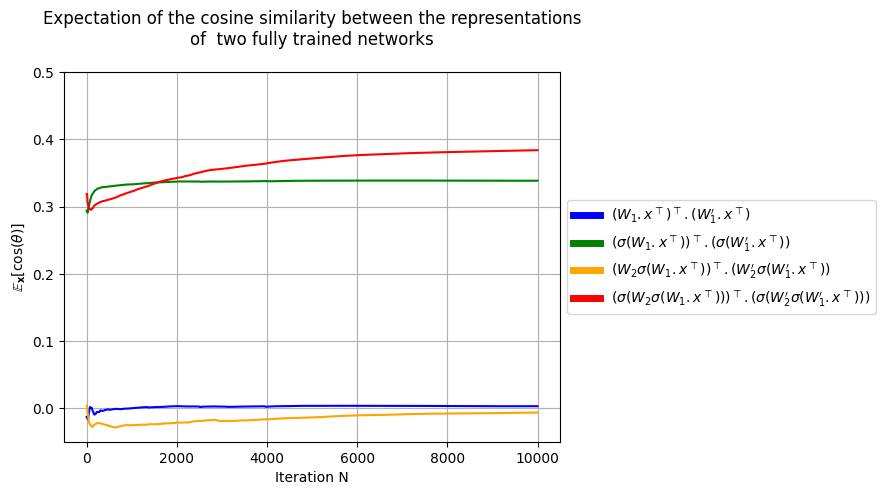

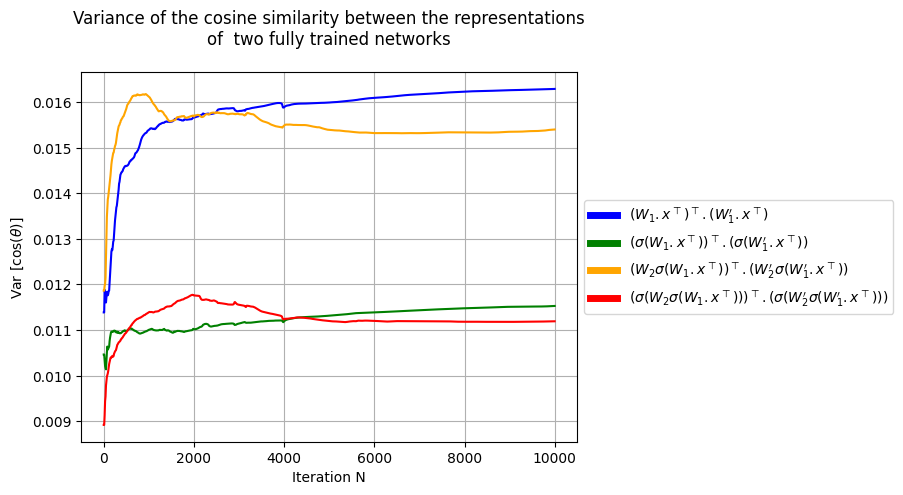

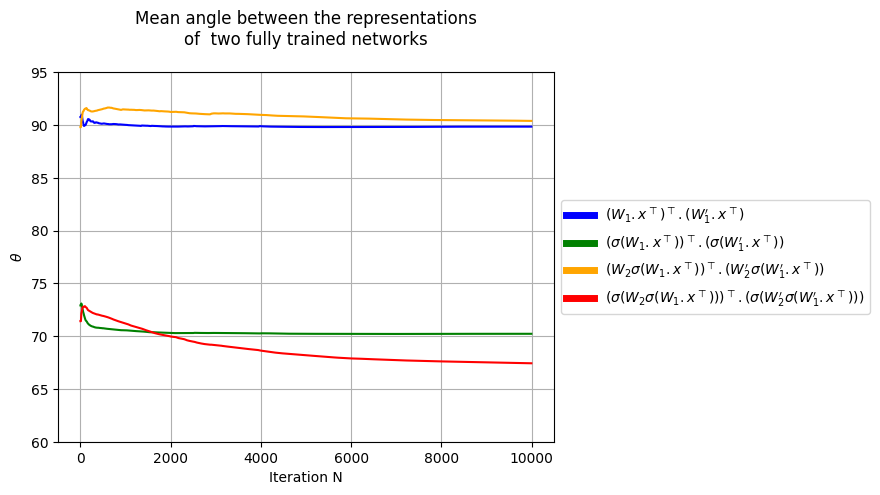

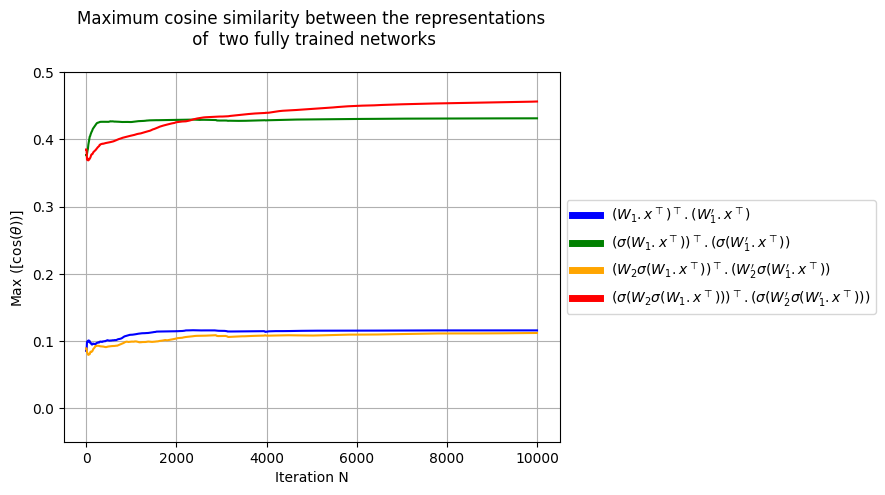

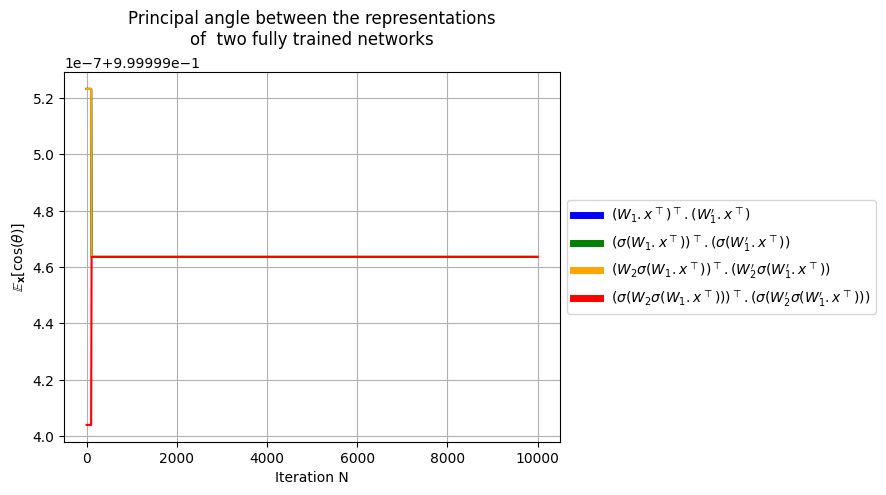

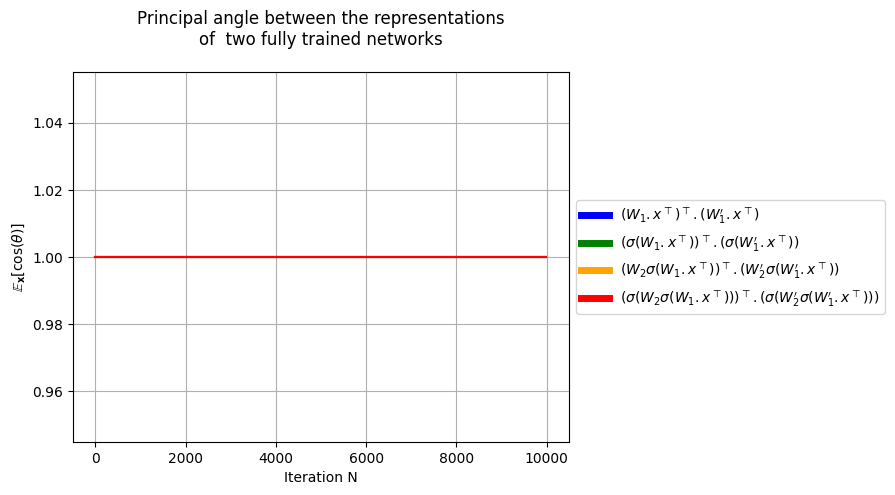

{'normalized_cross_scalar_product_matrix_trace_trajectory': {'data': {1: {'preactivation': [tensor(-0.0130),
     tensor(-0.0130),
     tensor(-0.0157),
     tensor(-0.0171),
     tensor(-0.0119),
     tensor(-0.0063),
     tensor(-0.0039),
     tensor(0.0004),
     tensor(0.0017),
     tensor(0.0009),
     tensor(0.0004),
     tensor(0.0004),
     tensor(-0.0009),
     tensor(-0.0033),
     tensor(-0.0051),
     tensor(-0.0060),
     tensor(-0.0082),
     tensor(-0.0098),
     tensor(-0.0093),
     tensor(-0.0085),
     tensor(-0.0087),
     tensor(-0.0078),
     tensor(-0.0063),
     tensor(-0.0058),
     tensor(-0.0058),
     tensor(-0.0056),
     tensor(-0.0057),
     tensor(-0.0060),
     tensor(-0.0058),
     tensor(-0.0049),
     tensor(-0.0038),
     tensor(-0.0034),
     tensor(-0.0035),
     tensor(-0.0036),
     tensor(-0.0042),
     tensor(-0.0042),
     tensor(-0.0040),
     tensor(-0.0037),
     tensor(-0.0036),
     tensor(-0.0036),
     tensor(-0.0029),
     tensor(-0.0

In [61]:
##### 08/07 - Correlations between representations on CIFAR-10 : car-plane #####



date = '01_07_25'

dataset = 'c-p_muP'

save_path = 'Post-processing/10_07_25/'
save_path_convergence_speed = save_path + 'Convergence speed/Dataset_' + dataset + '_statistical_results/'
save_path_normalized_convergence_speed = save_path + 'Normalized convergence speed/Dataset_' + dataset + '_statistical_results/'
save_path_max_accuracy = save_path + 'Maximum accuracy/Dataset_' + dataset + '_statistical_results/'
save_path_accuracy_trajectory = save_path + 'Accuracy trajectory/Dataset_' + dataset + '_statistical_results/'
save_path_loss_trajectory = save_path + 'Loss trajectory/Dataset_' + dataset + '_statistical_results/'
save_path_overlap = save_path + 'Overlaps/Dataset_' + dataset + '/'
save_path_covariances = save_path + 'Covariances/Dataset_' + dataset + '/'


os.makedirs(save_path_convergence_speed, exist_ok=True)
os.makedirs(save_path_normalized_convergence_speed, exist_ok=True)
os.makedirs(save_path_max_accuracy, exist_ok=True)
os.makedirs(save_path_accuracy_trajectory, exist_ok=True)
os.makedirs(save_path_loss_trajectory, exist_ok=True)
os.makedirs(save_path_overlap, exist_ok=True)
os.makedirs(save_path_covariances, exist_ok=True)


model_ref_1 = load_data_dictionnary("CIFAR10_torch_model_(1024+1024.2+1)_" + dataset + '_fully_trained_1', date)
model_ref_2 = load_data_dictionnary("CIFAR10_torch_model_(1024+1024.2+1)_" + dataset + '_fully_trained_2', date)
representation_overlap_trajectories(model_ref_1, model_ref_2, x_valid, save_path=save_path_overlap, architecture='(1024+1024.2+1)', add_to_title=' two fully trained networks')
